# ML Final Project Hotel Data Insights

By: Ido Natan, Tomer Yona, Yuval Levy
In this project we use a dataset with over 150,000 entries based on real booking reservations made from various hotels in New York City.
Througout the project we will use different models in order to predict discount codes from features such as: Weekday, snapshot date, checkin date, Day Diff (nm. of days between snapshot dat to chekcin date), hotel name.

### Imports

In [156]:
#imports
import pandas as pd
import numpy as np
import datetime
import copy
from sklearn import tree
from sklearn import preprocessing
import seaborn as sns



from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve

from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score

# Visualization Modules imports
from graphviz import Source
from IPython.display import SVG
import matplotlib.pyplot as plt

# Resampling
from sklearn.utils import resample
#import TreeClassifier
from sklearn.tree import DecisionTreeClassifier

#imports for running NB alog
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,auc,roc_auc_score
from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score

#import for xgboost
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb

from sklearn import tree
from sklearn.ensemble import RandomForestClassifier

#import for NN
import numpy as np
import torch
import sys
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils import data
from torchvision import transforms
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt

import time

from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset, DataLoader

#import for clustering
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from sklearn.cluster import AgglomerativeClustering
from sklearn.datasets import make_blobs
import scipy.cluster.hierarchy as sch


from sklearn.metrics import silhouette_score

from sklearn.preprocessing import StandardScaler

#import active learning
import modAL
from modAL.models import ActiveLearner
from modAL.uncertainty import entropy_sampling
from modAL.uncertainty import uncertainty_sampling
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, RBF
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression

In [157]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


# Section A: Create Hotels_data_changed.csv

In [158]:
df_a = pd.read_csv("hotels_data.csv")

In [159]:
df_a.head()

,Snapshot ID,Snapshot Date,Checkin Date,Days,Original Price,Discount Price,Discount Code,Available Rooms,Hotel Name,Hotel Stars
0,1,7/17/2015 0:00,8/12/2015 0:00,5,1178,1040,1,6,Best Western Plus Seaport Inn Downtown,3
1,1,7/17/2015 0:00,8/19/2015 0:00,5,1113,982,1,8,Best Western Plus Seaport Inn Downtown,3
2,1,7/17/2015 0:00,8/13/2015 0:00,5,4370,4240,1,3,The Peninsula New York,5
3,1,7/17/2015 0:00,7/26/2015 0:00,5,1739,1667,1,18,Eventi Hotel a Kimpton Hotel,4
4,1,7/17/2015 0:00,8/12/2015 0:00,5,1739,1672,1,3,Eventi Hotel a Kimpton Hotel,4


In [160]:
#aux func to convert string to date
def string_toDate(str_date):
    date_arr = str_date.split('/')
    year_arr = date_arr[2].split()
    year = int(year_arr[0])
    month = int(date_arr[0])
    day = int(date_arr[1])
    date = datetime.datetime(year,month,day)
    return date
    


def compute_day_diff(checkin_date, snapshot_date):
    x= string_toDate(checkin_date)
    y = string_toDate(snapshot_date)
    return(abs((x - y).days))

DayDiff = []
WeekDay = []
DiscountDiff = []
DiscountPerc = []
for index, row in df_a.iterrows():
    #Add Day difference to DayDiff list
    DayDiff.append(compute_day_diff(row['Checkin Date'], row['Snapshot Date']))
    date_format = string_toDate(row['Checkin Date'])
    #Return the day of the week as an integer, where Monday is 0 and Sunday is 6.
    WeekDay.append(date_format.weekday())
    #subtract discount price from original price 
    discount_in_usd = row['Original Price'] - row['Discount Price']
    #add discount in usd to list
    DiscountDiff.append(discount_in_usd)
    #compute precentage and add discount in % to list
    DiscountPerc.append((discount_in_usd / row['Original Price']) * 100)

 
# Add list to Data Frame
df_a['DayDiff'] = DayDiff
df_a['WeekDay'] = WeekDay
df_a['DiscountDiff'] = DiscountDiff
df_a['DiscountPerc'] = DiscountPerc

df_a.head()

df_a['WeekDay'] = df_a.WeekDay.astype('category')
df_a['DayDiff'] = df_a.DayDiff.astype('category')


In [161]:
df_a


,Snapshot ID,Snapshot Date,Checkin Date,Days,Original Price,Discount Price,Discount Code,Available Rooms,Hotel Name,Hotel Stars,DayDiff,WeekDay,DiscountDiff,DiscountPerc
0,1,7/17/2015 0:00,8/12/2015 0:00,5,1178,1040,1,6,Best Western Plus Seaport Inn Downtown,3,26,2,138,11.714771
1,1,7/17/2015 0:00,8/19/2015 0:00,5,1113,982,1,8,Best Western Plus Seaport Inn Downtown,3,33,2,131,11.769991
2,1,7/17/2015 0:00,8/13/2015 0:00,5,4370,4240,1,3,The Peninsula New York,5,27,3,130,2.974828
3,1,7/17/2015 0:00,7/26/2015 0:00,5,1739,1667,1,18,Eventi Hotel a Kimpton Hotel,4,9,6,72,4.140311
4,1,7/17/2015 0:00,8/12/2015 0:00,5,1739,1672,1,3,Eventi Hotel a Kimpton Hotel,4,26,2,67,3.852789
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187843,99,8/15/2015 0:00,9/4/2015 0:00,5,1995,1935,4,-1,Cassa Hotel 45th Street,4,20,4,60,3.007519
187844,99,8/15/2015 0:00,9/4/2015 0:00,5,2105,1865,4,4,The Jade Hotel,4,20,4,240,11.401425
187845,99,8/15/2015 0:00,8/20/2015 0:00,5,1456,1397,4,8,Hyatt Union Square New York,4,5,3,59,4.052198
187846,99,8/15/2015 0:00,9/2/2015 0:00,5,1705,1648,4,2,Hyatt Union Square New York,4,18,2,57,3.343109


In [162]:
df_a.to_csv("Hotels_data_changed.csv")

# Preperation of data for Section B

In [163]:
df_b = pd.read_csv("Hotels_data_changed.csv")
features = ['Snapshot Date', 'Checkin Date', 'Hotel Name', 'WeekDay', 'DayDiff','DiscountDiff','Discount Code']
workable_df = df_b.filter(items = features)
workable_df.head()

,Snapshot Date,Checkin Date,Hotel Name,WeekDay,DayDiff,DiscountDiff,Discount Code
0,7/17/2015 0:00,8/12/2015 0:00,Best Western Plus Seaport Inn Downtown,2,26,138,1
1,7/17/2015 0:00,8/19/2015 0:00,Best Western Plus Seaport Inn Downtown,2,33,131,1
2,7/17/2015 0:00,8/13/2015 0:00,The Peninsula New York,3,27,130,1
3,7/17/2015 0:00,7/26/2015 0:00,Eventi Hotel a Kimpton Hotel,6,9,72,1
4,7/17/2015 0:00,8/12/2015 0:00,Eventi Hotel a Kimpton Hotel,2,26,67,1


In [164]:
df_b1 = df_b.loc[:, ['WeekDay','Snapshot Date','Checkin Date','DayDiff','Hotel Name','Discount Code']]
df_b1['Snapshot Date'] = df_b1['Snapshot Date'].apply(lambda x: (pd.Timestamp(x) - pd.Timestamp('1991-01-01T12')).days)
df_b1['Checkin Date'] = df_b1['Checkin Date'].apply(lambda x: (pd.Timestamp(x) - pd.Timestamp('1991-01-01T12')).days)

# workable df
cols = ['Snapshot Date', 'Checkin Date', 'Hotel Name', 'WeekDay', 'DayDiff', 'Discount Code']
df_b2 = df_b1.filter(cols)
df_b2.head()

,Snapshot Date,Checkin Date,Hotel Name,WeekDay,DayDiff,Discount Code
0,8962,8988,Best Western Plus Seaport Inn Downtown,2,26,1
1,8962,8995,Best Western Plus Seaport Inn Downtown,2,33,1
2,8962,8989,The Peninsula New York,3,27,1
3,8962,8971,Eventi Hotel a Kimpton Hotel,6,9,1
4,8962,8988,Eventi Hotel a Kimpton Hotel,2,26,1


# Preperation of data for Section C

In [165]:
df_c = pd.read_csv("Hotels_data_changed.csv")
df_c = df_c.drop('Unnamed: 0', axis=1)
df_c


,Snapshot ID,Snapshot Date,Checkin Date,Days,Original Price,Discount Price,Discount Code,Available Rooms,Hotel Name,Hotel Stars,DayDiff,WeekDay,DiscountDiff,DiscountPerc
0,1,7/17/2015 0:00,8/12/2015 0:00,5,1178,1040,1,6,Best Western Plus Seaport Inn Downtown,3,26,2,138,11.714771
1,1,7/17/2015 0:00,8/19/2015 0:00,5,1113,982,1,8,Best Western Plus Seaport Inn Downtown,3,33,2,131,11.769991
2,1,7/17/2015 0:00,8/13/2015 0:00,5,4370,4240,1,3,The Peninsula New York,5,27,3,130,2.974828
3,1,7/17/2015 0:00,7/26/2015 0:00,5,1739,1667,1,18,Eventi Hotel a Kimpton Hotel,4,9,6,72,4.140311
4,1,7/17/2015 0:00,8/12/2015 0:00,5,1739,1672,1,3,Eventi Hotel a Kimpton Hotel,4,26,2,67,3.852789
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187843,99,8/15/2015 0:00,9/4/2015 0:00,5,1995,1935,4,-1,Cassa Hotel 45th Street,4,20,4,60,3.007519
187844,99,8/15/2015 0:00,9/4/2015 0:00,5,2105,1865,4,4,The Jade Hotel,4,20,4,240,11.401425
187845,99,8/15/2015 0:00,8/20/2015 0:00,5,1456,1397,4,8,Hyatt Union Square New York,4,5,3,59,4.052198
187846,99,8/15/2015 0:00,9/2/2015 0:00,5,1705,1648,4,2,Hyatt Union Square New York,4,18,2,57,3.343109


In [166]:
# find the 150 most occuring hotel names

# get top 10 most frequent names
n = 150
hotels = df_c['Hotel Name'].value_counts()[:n].index.tolist()

In [167]:
# find the mod (limited to 40) 40 checkin dates with most 
n = 40
checkin_dates = df_c['Checkin Date'].value_counts()[:n].index.tolist()

In [168]:
test_df = pd.DataFrame(columns=list(df_c.columns))
for hotel in hotels:
    test_df = test_df.append(df_c[df_c["Hotel Name"] == hotel])

In [169]:
check_df = test_df.copy(deep=True)
for checkin in df_c['Checkin Date'].unique():
    if checkin not in checkin_dates:
        check_df = check_df[check_df["Checkin Date"] != checkin]

In [170]:
check_df["Actual Price"] = check_df['Original Price'] - check_df['Discount Price']  
check_df

,Snapshot ID,Snapshot Date,Checkin Date,Days,Original Price,Discount Price,Discount Code,Available Rooms,Hotel Name,Hotel Stars,DayDiff,WeekDay,DiscountDiff,DiscountPerc,Actual Price
69,1,7/17/2015 0:00,8/12/2015 0:00,5,1143,795,1,-1,Newark Liberty International Airport Marriott,4,26,2,348,30.446194,348
70,1,7/17/2015 0:00,8/19/2015 0:00,5,1156,753,1,-1,Newark Liberty International Airport Marriott,4,33,2,403,34.861592,403
336,1,7/17/2015 0:00,8/12/2015 0:00,5,1143,872,2,-1,Newark Liberty International Airport Marriott,4,26,2,271,23.709536,271
339,1,7/17/2015 0:00,8/19/2015 0:00,5,1156,836,2,-1,Newark Liberty International Airport Marriott,4,33,2,320,27.681661,320
652,1,7/17/2015 0:00,8/12/2015 0:00,5,1143,982,3,-1,Newark Liberty International Airport Marriott,4,26,2,161,14.085739,161
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126853,504,11/8/2015 0:00,11/26/2015 0:00,5,1077,1012,1,5,TRYP By Wyndham Times Square South,5,18,3,65,6.035283,65
128266,506,11/9/2015 0:00,11/26/2015 0:00,5,1077,1012,1,4,TRYP By Wyndham Times Square South,5,17,3,65,6.035283,65
129647,508,11/10/2015 0:00,11/26/2015 0:00,5,1105,1032,1,6,TRYP By Wyndham Times Square South,5,16,3,73,6.606335,73
131015,511,11/11/2015 0:00,11/26/2015 0:00,5,1110,1043,1,5,TRYP By Wyndham Times Square South,5,15,3,67,6.036036,67


In [171]:
original_cols = check_df.columns
df_builder = pd.DataFrame(columns=original_cols)
for hotel in hotels:
    for checkin in checkin_dates:
        temporary_df_1 = check_df[check_df["Hotel Name"] == hotel]
        temporary_df_2 = temporary_df_1[temporary_df_1["Checkin Date"] == checkin]
        temporary_df_2 = temporary_df_2.sort_values("Actual Price")
        temporary_df_code_1 = temporary_df_2[temporary_df_2["Discount Code"] == 1]
        temporary_df_code_2 = temporary_df_2[temporary_df_2["Discount Code"] == 2]
        temporary_df_code_3 = temporary_df_2[temporary_df_2["Discount Code"] == 3]
        temporary_df_code_4 = temporary_df_2[temporary_df_2["Discount Code"] == 4]
        if not (temporary_df_code_1.empty):
            to_add = pd.DataFrame(temporary_df_code_1.iloc[[0], :])
            df_builder = pd.concat([df_builder,to_add])
        else:
            code = 1
            to_add = pd.DataFrame({original_cols[0]: [-1], original_cols[1]: [-1], original_cols[2]: [checkin],
                                   original_cols[3]: [-1], original_cols[4]: [-1], original_cols[5]: [-1],
                                   original_cols[6]: [code], original_cols[7]: [-1], original_cols[8]: [hotel],
                                   original_cols[9]: [-1], original_cols[10]: [-1]})

            df_builder = pd.concat([df_builder,to_add])
        if not (temporary_df_code_2.empty):
            to_add = pd.DataFrame(temporary_df_code_2.iloc[[0], :])
            df_builder = pd.concat([df_builder,to_add])
        else:
            code = 2
            to_add = pd.DataFrame({original_cols[0]: [-1], original_cols[1]: [-1], original_cols[2]: [checkin],
                                   original_cols[3]: [-1], original_cols[4]: [-1], original_cols[5]: [-1],
                                   original_cols[6]: [code], original_cols[7]: [-1], original_cols[8]: [hotel],
                                   original_cols[9]: [-1], original_cols[10]: [-1]})

            df_builder = pd.concat([df_builder,to_add])
        if not (temporary_df_code_3.empty):
            to_add = pd.DataFrame(temporary_df_code_3.iloc[[0], :])
            df_builder = pd.concat([df_builder,to_add])
        else:
            code = 3
            to_add = pd.DataFrame({original_cols[0]: [-1], original_cols[1]: [-1], original_cols[2]: [checkin],
                                   original_cols[3]: [-1], original_cols[4]: [-1], original_cols[5]: [-1],
                                   original_cols[6]: [code], original_cols[7]: [-1], original_cols[8]: [hotel],
                                   original_cols[9]: [-1], original_cols[10]: [-1]})

            df_builder = pd.concat([df_builder,to_add])
        if not (temporary_df_code_4.empty):
            to_add = pd.DataFrame(temporary_df_code_4.iloc[[0], :])
            df_builder = pd.concat([df_builder,to_add])
        else:
            code = 4
            to_add = pd.DataFrame({original_cols[0]: [-1], original_cols[1]: [-1], original_cols[2]: [checkin],
                                   original_cols[3]: [-1], original_cols[4]: [-1], original_cols[5]: [-1],
                                   original_cols[6]: [code], original_cols[7]: [-1], original_cols[8]: [hotel],
                                   original_cols[9]: [-1], original_cols[10]: [-1]})

            df_builder = pd.concat([df_builder,to_add])

In [172]:
pre_normalization_df = df_builder.copy(deep=True)

In [173]:
# normalize function

def normalize_prices(value, max_val):
    if value == -1:
        return value
    return (value/max_val)*100

In [174]:
max_value = pre_normalization_df["Actual Price"].max()
max_value

2560

In [175]:
# Normalize prices
new_df = pre_normalization_df.copy(deep=True)
new_df["Actual Price"] = pre_normalization_df["Actual Price"].apply(normalize_prices, max_val=max_value).astype(float)
new_df

,Snapshot ID,Snapshot Date,Checkin Date,Days,Original Price,Discount Price,Discount Code,Available Rooms,Hotel Name,Hotel Stars,DayDiff,WeekDay,DiscountDiff,DiscountPerc,Actual Price
80178,442,10/8/2015 0:00,11/11/2015 0:00,5,1144,838,1,-1,Newark Liberty International Airport Marriott,4,34,2,306,26.748252,11.953125
114897,491,11/1/2015 0:00,11/11/2015 0:00,5,1195,957,2,5,Newark Liberty International Airport Marriott,4,10,2,238,19.916318,9.296875
85140,448,10/11/2015 0:00,11/11/2015 0:00,5,1144,1008,3,-1,Newark Liberty International Airport Marriott,4,31,2,136,11.888112,5.312500
0,-1,-1,11/11/2015 0:00,-1,-1,-1,4,-1,Newark Liberty International Airport Marriott,-1,-1,NaN,NaN,NaN,NaN
85746,450,10/12/2015 0:00,10/28/2015 0:00,5,1110,788,1,-1,Newark Liberty International Airport Marriott,4,16,2,322,29.009009,12.578125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69540,428,10/1/2015 0:00,10/31/2015 0:00,5,1373,1307,4,2,TRYP By Wyndham Times Square South,5,30,5,66,4.806992,2.578125
0,-1,-1,10/7/2015 0:00,-1,-1,-1,1,-1,TRYP By Wyndham Times Square South,-1,-1,NaN,NaN,NaN,NaN
0,-1,-1,10/7/2015 0:00,-1,-1,-1,2,-1,TRYP By Wyndham Times Square South,-1,-1,NaN,NaN,NaN,NaN
0,-1,-1,10/7/2015 0:00,-1,-1,-1,3,-1,TRYP By Wyndham Times Square South,-1,-1,NaN,NaN,NaN,NaN


In [176]:
clustering_df = pd.DataFrame(new_df[['Hotel Name', 'Snapshot Date', 'Discount Code', 'Actual Price', 'Checkin Date']])
clustering_df

,Hotel Name,Snapshot Date,Discount Code,Actual Price,Checkin Date
80178,Newark Liberty International Airport Marriott,10/8/2015 0:00,1,11.953125,11/11/2015 0:00
114897,Newark Liberty International Airport Marriott,11/1/2015 0:00,2,9.296875,11/11/2015 0:00
85140,Newark Liberty International Airport Marriott,10/11/2015 0:00,3,5.312500,11/11/2015 0:00
0,Newark Liberty International Airport Marriott,-1,4,NaN,11/11/2015 0:00
85746,Newark Liberty International Airport Marriott,10/12/2015 0:00,1,12.578125,10/28/2015 0:00
...,...,...,...,...,...
69540,TRYP By Wyndham Times Square South,10/1/2015 0:00,4,2.578125,10/31/2015 0:00
0,TRYP By Wyndham Times Square South,-1,1,NaN,10/7/2015 0:00
0,TRYP By Wyndham Times Square South,-1,2,NaN,10/7/2015 0:00
0,TRYP By Wyndham Times Square South,-1,3,NaN,10/7/2015 0:00


In [177]:
p_df = clustering_df.pivot_table(values='Actual Price', index='Hotel Name', columns=['Checkin Date', 'Discount Code'])
p_df

Checkin Date                                   10/1/2015 0:00           \
Discount Code                                               1        2   
Hotel Name                                                               
Aloft Harlem                                              NaN      NaN   
Andaz 5th Avenue - a concept by Hyatt               10.546875  6.25000   
Andaz Wall Street - a concept by Hyatt                    NaN  4.21875   
Baccarat Hotel and Residences New York                    NaN      NaN   
Bentley Hotel                                             NaN      NaN   
...                                                       ...      ...   
Wyndham Garden Brooklyn Sunset Park                       NaN      NaN   
Wyndham Garden Chinatown                                  NaN      NaN   
Wyndham Garden Long Island City Manhattan View            NaN      NaN   
Wyndham New Yorker                                        NaN      NaN   
ink48 hotel a Kimpton Hotel                          6.835938      NaN   

Checkin Date                                                        \
Discount Code                                          3         4   
Hotel Name                                                           
Aloft Harlem                                         NaN       NaN   
Andaz 5th Avenue - a concept by Hyatt           3.515625  3.125000   
Andaz Wall Street - a concept by Hyatt               NaN  3.515625   
Baccarat Hotel and Residences New York               NaN       NaN   
Bentley Hotel                                        NaN       NaN   
...                                                  ...       ...   
Wyndham Garden Brooklyn Sunset Park                  NaN       NaN   
Wyndham Garden Chinatown                             NaN       NaN   
Wyndham Garden Long Island City Manhattan View       NaN       NaN   
Wyndham New Yorker                                   NaN       NaN   
ink48 hotel a Kimpton Hotel                     3.007812       NaN   

Checkin Date                                   10/14/2015 0:00            \
Discount Code                                                1         2   
Hotel Name                                                                 
Aloft Harlem                                          2.812500       NaN   
Andaz 5th Avenue - a concept by Hyatt                      NaN  3.906250   
Andaz Wall Street - a concept by Hyatt                2.929688  3.906250   
Baccarat Hotel and Residences New York                     NaN       NaN   
Bentley Hotel                                              NaN       NaN   
...                                                        ...       ...   
Wyndham Garden Brooklyn Sunset Park                        NaN  2.070312   
Wyndham Garden Chinatown                                   NaN       NaN   
Wyndham Garden Long Island City Manhattan View             NaN       NaN   
Wyndham New Yorker                                         NaN       NaN   
ink48 hotel a Kimpton Hotel                                NaN       NaN   

Checkin Date                                                        \
Discount Code                                          3         4   
Hotel Name                                                           
Aloft Harlem                                    5.117188       NaN   
Andaz 5th Avenue - a concept by Hyatt                NaN       NaN   
Andaz Wall Street - a concept by Hyatt          4.882812       NaN   
Baccarat Hotel and Residences New York               NaN       NaN   
Bentley Hotel                                        NaN       NaN   
...                                                  ...       ...   
Wyndham Garden Brooklyn Sunset Park             3.164062  3.554688   
Wyndham Garden Chinatown                             NaN       NaN   
Wyndham Garden Long Island City Manhattan View  3.085938       NaN   
Wyndham New Yorker                                   NaN       NaN   
ink48 h

In [178]:
p_df.fillna(-1, inplace=True)
p_df

Checkin Date                                   10/1/2015 0:00           \
Discount Code                                               1        2   
Hotel Name                                                               
Aloft Harlem                                        -1.000000 -1.00000   
Andaz 5th Avenue - a concept by Hyatt               10.546875  6.25000   
Andaz Wall Street - a concept by Hyatt              -1.000000  4.21875   
Baccarat Hotel and Residences New York              -1.000000 -1.00000   
Bentley Hotel                                       -1.000000 -1.00000   
...                                                       ...      ...   
Wyndham Garden Brooklyn Sunset Park                 -1.000000 -1.00000   
Wyndham Garden Chinatown                            -1.000000 -1.00000   
Wyndham Garden Long Island City Manhattan View      -1.000000 -1.00000   
Wyndham New Yorker                                  -1.000000 -1.00000   
ink48 hotel a Kimpton Hotel                          6.835938 -1.00000   

Checkin Date                                                        \
Discount Code                                          3         4   
Hotel Name                                                           
Aloft Harlem                                   -1.000000 -1.000000   
Andaz 5th Avenue - a concept by Hyatt           3.515625  3.125000   
Andaz Wall Street - a concept by Hyatt         -1.000000  3.515625   
Baccarat Hotel and Residences New York         -1.000000 -1.000000   
Bentley Hotel                                  -1.000000 -1.000000   
...                                                  ...       ...   
Wyndham Garden Brooklyn Sunset Park            -1.000000 -1.000000   
Wyndham Garden Chinatown                       -1.000000 -1.000000   
Wyndham Garden Long Island City Manhattan View -1.000000 -1.000000   
Wyndham New Yorker                             -1.000000 -1.000000   
ink48 hotel a Kimpton Hotel                     3.007812 -1.000000   

Checkin Date                                   10/14/2015 0:00            \
Discount Code                                                1         2   
Hotel Name                                                                 
Aloft Harlem                                          2.812500 -1.000000   
Andaz 5th Avenue - a concept by Hyatt                -1.000000  3.906250   
Andaz Wall Street - a concept by Hyatt                2.929688  3.906250   
Baccarat Hotel and Residences New York               -1.000000 -1.000000   
Bentley Hotel                                        -1.000000 -1.000000   
...                                                        ...       ...   
Wyndham Garden Brooklyn Sunset Park                  -1.000000  2.070312   
Wyndham Garden Chinatown                             -1.000000 -1.000000   
Wyndham Garden Long Island City Manhattan View       -1.000000 -1.000000   
Wyndham New Yorker                                   -1.000000 -1.000000   
ink48 hotel a Kimpton Hotel                          -1.000000 -1.000000   

Checkin Date                                                        \
Discount Code                                          3         4   
Hotel Name                                                           
Aloft Harlem                                    5.117188 -1.000000   
Andaz 5th Avenue - a concept by Hyatt          -1.000000 -1.000000   
Andaz Wall Street - a concept by Hyatt          4.882812 -1.000000   
Baccarat Hotel and Residences New York         -1.000000 -1.000000   
Bentley Hotel                                  -1.000000 -1.000000   
...                                                  ...       ...   
Wyndham Garden Brooklyn Sunset Park             3.164062  3.554688   
Wyndham Garden Chinatown                       -1.000000 -1.000000   
Wyndham Garden Long Island City Manhattan View  3.085938 -1.000000   
Wyndham New Yorker                             -1.000000 -1.000000   
ink48 h

In [179]:
p_df.describe()

Checkin Date  10/1/2015 0:00                                      \
Discount Code              1           2           3           4   
count             149.000000  149.000000  149.000000  149.000000   
mean                0.822777    1.468383    1.190961    1.438601   
std                 3.477372    5.126049    3.929550    4.835179   
min                -1.000000   -1.000000   -1.000000   -1.000000   
25%                -1.000000   -1.000000   -1.000000   -1.000000   
50%                -1.000000   -1.000000   -1.000000   -1.000000   
75%                 2.343750    2.890625    2.773438    2.734375   
max                19.218750   46.875000   21.796875   28.906250   

Checkin Date  10/14/2015 0:00                                      \
Discount Code               1           2           3           4   
count              149.000000  149.000000  149.000000  149.000000   
mean                 1.902318    2.145082    1.734165    0.720271   
std                  5.183027    3.789694    3.149421    2.576594   
min                 -1.000000   -1.000000   -1.000000   -1.000000   
25%                 -1.000000   -1.000000   -1.000000   -1.000000   
50%                 -1.000000    1.992187    1.992187   -1.000000   
75%                  3.125000    4.296875    3.632813    2.656250   
max                 28.125000   16.601562   14.062500   11.914062   

Checkin Date  10/15/2015 0:00              ... 9/18/2015 0:00              \
Discount Code               1           2  ...              3           4   
count              149.000000  149.000000  ...     149.000000  149.000000   
mean                 0.533557    1.346739  ...       1.642722    0.495910   
std                  2.886595    2.961981  ...       4.642926    3.345719   
min                 -1.000000   -1.000000  ...      -1.000000   -1.000000   
25%                 -1.000000   -1.000000  ...      -1.000000   -1.000000   
50%                 -1.000000   -1.000000  ...      -1.000000   -1.000000   
75%                  1.992187    3.085938  ...       3.554688   -1.000000   
max                 12.187500   11.718750  ...      26.718750   22.656250   

Checkin Date  9/30/2015 0:00                                      \
Discount Code              1           2           3           4   
count             149.000000  149.000000  149.000000  149.000000   
mean                1.495596    1.467072    1.266621    0.397284   
std                 5.154430    4.918676    3.954971    2.734947   
min                -1.000000   -1.000000   -1.000000   -1.000000   
25%                -1.000000   -1.000000   -1.000000   -1.000000   
50%                -1.000000   -1.000000   -1.000000   -1.000000   
75%                 3.085938    2.773438    2.851562    2.031250   
max                42.187500   35.156250   23.437500   13.281250   

Checkin Date  9/9/2015 0:00                                      
Discount Code             1           2           3           4  
count            149.000000  149.000000  149.000000  149.000000  
mean               1.369442    1.955747    1.050388    0.173133  
std                5.607337    5.788668    3.157829    2.432441  
min               -1.000000   -1.000000   -1.000000   -1.000000  
25%               -1.000000   -1.000000   -1.000000   -1.000000  
50%               -1.000000   -1.000000   -1.000000   -1.000000  
75%                2.851562    3.164062    3.125000   -1.000000  
max               50.390625   42.968750   14.062500   13.671875  

[8 rows x 160 columns]

In [180]:
df_c1 = p_df.copy(deep=True)

# Preperation of data for Section D

### Helper

In [385]:
def process_df(raw_df):
    # Focus on one month after snapshot

    processed_df = raw_df.copy(deep=True)
    processed_df["interval"] = processed_df['Checkin Date'] - processed_df['Snapshot Date']
    processed_df.loc[:, "interval"] = processed_df.loc[:, "interval"]
    processed_df = processed_df[processed_df["interval"] > 0]
    processed_df = processed_df[processed_df["interval"] <= 30]
    processed_df = processed_df.drop("interval", axis=1)
    
    # hotel name set
    hotelNameSet = set()
    for index, row in raw_df.iterrows():
        hotelToAdd = row['Hotel Name']
        hotelNameSet.add(hotelToAdd)
        
    #dict for hotel name
    hotelNameDict = {}
    i = 0
    for val in hotelNameSet:
        hotelNameDict[val] = i
        i = i +1        
    
    processed_df['Hotel Name'] = raw_df['Hotel Name'].map(hotelNameDict)
      
#     print("After 30 day filtering and interval drop and number naming the hotels")
#     print(processed_df)
    return processed_df

In [386]:
df_d1 = df_a.copy(deep=True)
df_d1['Snapshot Date'] = df_d1['Snapshot Date'].apply(lambda x: (pd.Timestamp(x) - pd.Timestamp('1991-01-01T12')).days)
df_d1['Checkin Date'] = df_d1['Checkin Date'].apply(lambda x: (pd.Timestamp(x) - pd.Timestamp('1991-01-01T12')).days)

df_d_train = process_df(df_d1)
#df_d_train['DayDiff'].unique()

In [387]:
num_hotels = 40

In [388]:
most_informed_hotels = df_d_train['Hotel Name'].value_counts()[:num_hotels].sort_values(ascending=False)

#most_informed_hotels = train_df['Hotel Name'].value_counts()[:num_hotels].sort_values(ascending=False)
most_informed_hotels = most_informed_hotels.index.to_list()

In [389]:
df_d_test = df_d_train[df_d_train['Hotel Name'].isin(most_informed_hotels)]

In [391]:
df_d_test

,Snapshot ID,Snapshot Date,Checkin Date,Days,Original Price,Discount Price,Discount Code,Available Rooms,Hotel Name,Hotel Stars,DayDiff,WeekDay,DiscountDiff,DiscountPerc
5,1,8962,8983,5,1436,1345,1,9,300,4,21,4,91,6.337047
6,1,8962,8985,5,1616,1525,1,5,300,4,23,6,91,5.631188
7,1,8962,8988,5,1256,1183,1,5,300,4,26,2,73,5.812102
8,1,8962,8989,5,1256,1201,1,54,300,4,27,3,55,4.378981
14,1,8962,8967,5,3900,3750,1,8,440,5,5,2,150,3.846154
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187842,99,8991,9010,5,1895,1735,4,-1,435,4,19,3,160,8.443272
187843,99,8991,9011,5,1995,1935,4,-1,435,4,20,4,60,3.007519
187845,99,8991,8996,5,1456,1397,4,8,90,4,5,3,59,4.052198
187846,99,8991,9009,5,1705,1648,4,2,90,4,18,2,57,3.343109


# Back to Project Sections

## Section B: Classification

#### Raw Info From Hotels_data_changed

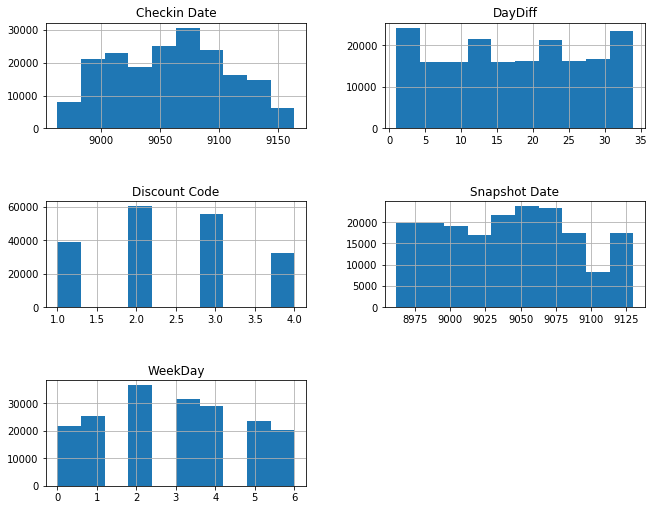

In [188]:
df_b2.hist()
plt.tight_layout(pad=4.0)
plt.show()

### We see here various histograms of number of hotels to features:  discount code 4 is the most least used on average, and Discount codes 2 most frequently used on average. At this point, we do not have enough understanding of the database, and we have chosen not to cut samples in order to obtain similar quantities.

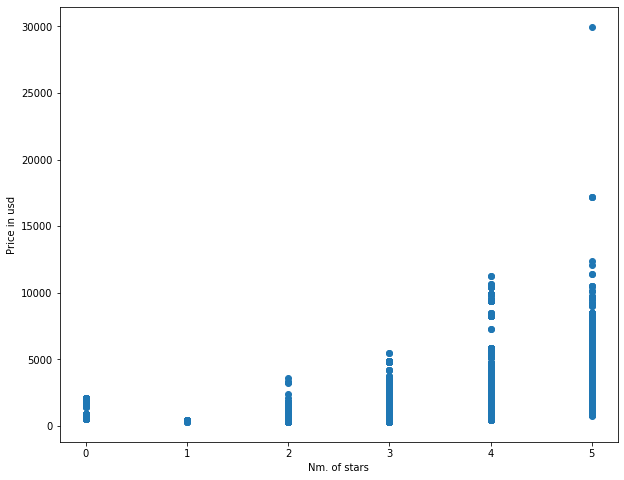

In [189]:
plt.scatter(df_a['Hotel Stars'], df_a['Original Price']) 
plt.xlabel("Nm. of stars")
plt.ylabel("Price in usd")
plt.show() 

### Here we see the samples of booking prices against the number of stars of the hotels. We see that there is one hotel whose booking price is significantly higher than the rest. At this point we will not delete this exceptional sample, mainly because the hotel rating will not go into the dataset on which we will make the analyze of the information.


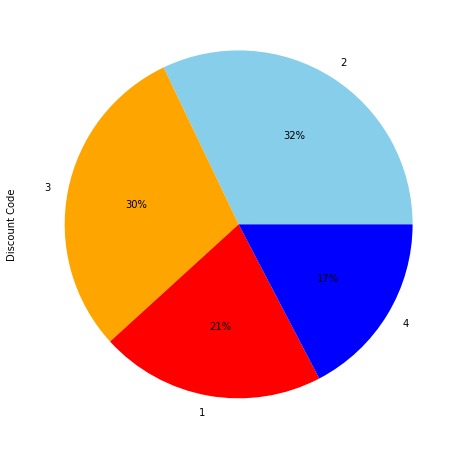

In [190]:

import matplotlib.pyplot as plt
import seaborn as sns
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size
df_b2['Discount Code'].value_counts().plot(kind='pie', autopct='%1.0f%%', colors=['skyblue', 'orange', 'red', 'blue'])

### We can see here that the targets are dived relatively in an unbias way which is good

### Now create a supervised dataframe for predicting better discount codes

In [191]:
df_b3 = df_b.sort_values('DiscountPerc', ascending=False).drop_duplicates(['Hotel Name', 'Snapshot Date', 'Checkin Date']).sort_index()

In [192]:
df_b3.head()

,Unnamed: 0,Snapshot ID,Snapshot Date,Checkin Date,Days,Original Price,Discount Price,Discount Code,Available Rooms,Hotel Name,Hotel Stars,DayDiff,WeekDay,DiscountDiff,DiscountPerc
0,0,1,7/17/2015 0:00,8/12/2015 0:00,5,1178,1040,1,6,Best Western Plus Seaport Inn Downtown,3,26,2,138,11.714771
1,1,1,7/17/2015 0:00,8/19/2015 0:00,5,1113,982,1,8,Best Western Plus Seaport Inn Downtown,3,33,2,131,11.769991
3,3,1,7/17/2015 0:00,7/26/2015 0:00,5,1739,1667,1,18,Eventi Hotel a Kimpton Hotel,4,9,6,72,4.140311
5,5,1,7/17/2015 0:00,8/7/2015 0:00,5,1436,1345,1,9,Grand Hyatt New York,4,21,4,91,6.337047
6,6,1,7/17/2015 0:00,8/9/2015 0:00,5,1616,1525,1,5,Grand Hyatt New York,4,23,6,91,5.631188


#### Some info on the supervised dataframe (We can see here the difference between our previous pie, not huge difference data is still unbias)

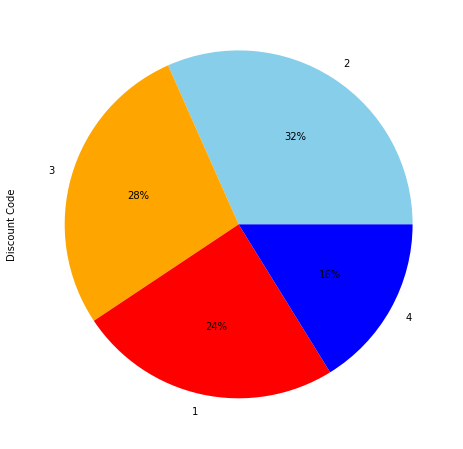

In [193]:

import matplotlib.pyplot as plt
import seaborn as sns
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size
df_b3['Discount Code'].value_counts().plot(kind='pie', autopct='%1.0f%%', colors=['skyblue', 'orange', 'red', 'blue'])

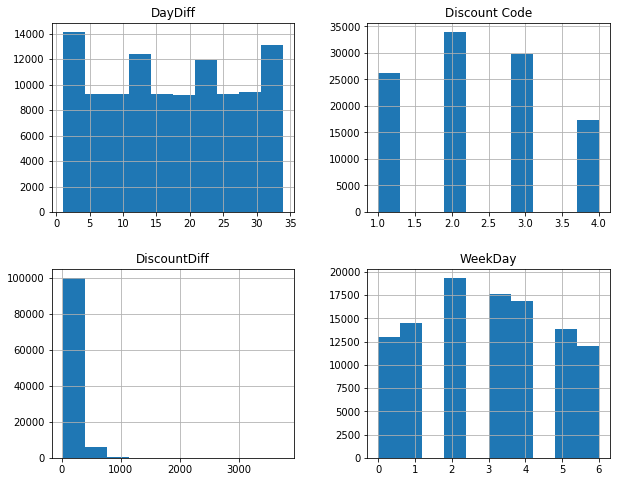

In [194]:
features = ['Snapshot Date', 'Checkin Date', 'Hotel Name', 'WeekDay', 'DayDiff','DiscountDiff','Discount Code']
workable_df = df_b3.filter(items = features)
workable_df.hist()
plt.show()

### Here we can see that we have less examples in the different features.

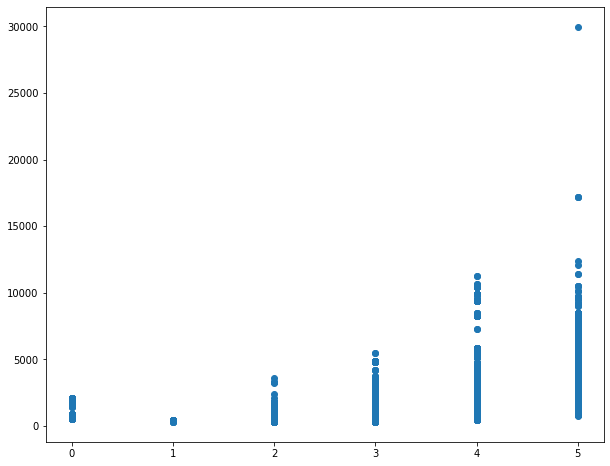

In [195]:
plt.scatter(df_b['Hotel Stars'], df_b['Original Price']) 
plt.show() 

## Here we can see that hotel stars indication of price remains mostly logical 

# Classifiction Algorithms

In [196]:
def transform_categorial(dataframe):
    

    dataframe['WeekDay'] = dataframe.WeekDay.astype('category')
    dataframe['DayDiff'] = dataframe.DayDiff.astype('category')
    #workable_df.dtypes

In [197]:
to_dummy = ['Hotel Name']
workable_df = pd.get_dummies(data=df_b3, columns=to_dummy)
workable_df = workable_df.replace(to_replace ="-1", 
                 value =np.nan)
workable_df.dropna(inplace = True)

#make features categorical
workable_df['Snapshot Date'] = workable_df['Snapshot Date'].apply(lambda x: (pd.Timestamp(x) - pd.Timestamp('1991-01-01T12')).days)
workable_df['Checkin Date'] = workable_df['Checkin Date'].apply(lambda x: (pd.Timestamp(x) - pd.Timestamp('1991-01-01T12')).days)

workable_df.head()

,Unnamed: 0,Snapshot ID,Snapshot Date,Checkin Date,Days,Original Price,Discount Price,Discount Code,Available Rooms,Hotel Stars,...,Hotel Name_Wyndham Garden Brooklyn Sunset Park,Hotel Name_Wyndham Garden Chinatown,Hotel Name_Wyndham Garden Hotel Newark Airport,Hotel Name_Wyndham Garden Long Island City Manhattan View,Hotel Name_Wyndham New Yorker,Hotel Name_YOTEL New York at Times Square,Hotel Name_Z NYC Hotel,Hotel Name_citizenM New York Times Square,Hotel Name_ink48 hotel a Kimpton Hotel,Hotel Name_the Quin
0,0,1,8962,8988,5,1178,1040,1,6,3,...,0,0,0,0,0,0,0,0,0,0
1,1,1,8962,8995,5,1113,982,1,8,3,...,0,0,0,0,0,0,0,0,0,0
3,3,1,8962,8971,5,1739,1667,1,18,4,...,0,0,0,0,0,0,0,0,0,0
5,5,1,8962,8983,5,1436,1345,1,9,4,...,0,0,0,0,0,0,0,0,0,0
6,6,1,8962,8985,5,1616,1525,1,5,4,...,0,0,0,0,0,0,0,0,0,0


## Naive Bayes

In [251]:
#aux function to the acuraccy of models
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = preprocessing.LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)
    return roc_auc_score(y_test, y_pred, average=average)


In [199]:
#Prepare Featurs and output
features = list(workable_df.columns)
features.remove('Discount Code')
X = workable_df[features]
y = workable_df['Discount Code']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3)



In [200]:

gnb = GaussianNB()
gnb.fit(X_train,y_train)
print(gnb)
y_pred = gnb.predict(X_test)

print("accuracy score: " + str(accuracy_score(y_test,y_pred)))



auc_score = multiclass_roc_auc_score(y_test,y_pred)
print("auc score: " + str(auc_score))

GaussianNB(priors=None, var_smoothing=1e-09)
accuracy score: 0.334327430879155
auc score: 0.5254923047887694


## GaussianNB() has no argument that it excepts there for cannot be improved.


In [201]:
def plot_matrix(model,X_test,y_test,y_pred):
    titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
    for title, normalize in titles_options:
        disp = plot_confusion_matrix(model, X_test, y_test,
                                 display_labels=['1', '2', '3', '4'],
                                 cmap=plt.cm.Greens,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    plt.show()
    confusion_matrix(y_test, y_pred)

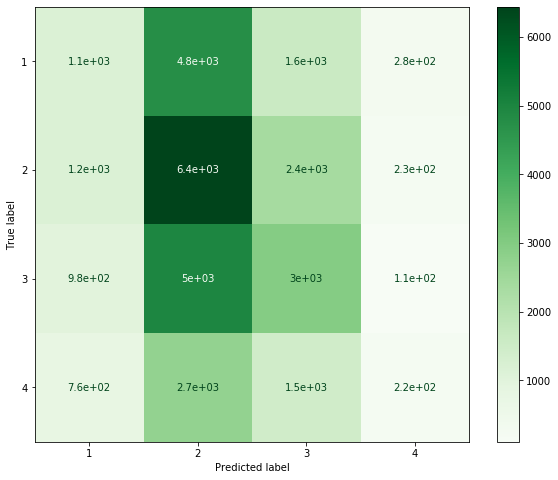

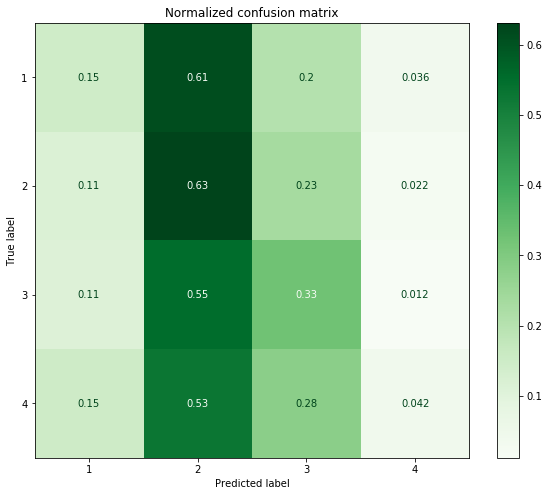

In [202]:
plot_matrix(gnb,X_test,y_test,y_pred)

# We notice that it is succsful classification for discount code 2, but the rest are not as good. Mostly 4 is not good at all - having the least amount of data on dicount code 4 might be the cause.

XGBOOST

n_estimators represents the number of trees in the forest. Usually the higher the number of trees the better to learn the data. However, adding a lot of trees can slow down the training process considerably, therefore we do a parameter search to find the sweet spot.

max_depth. This indicates how deep the built tree can be. The deeper the tree, the more splits it has and it captures more information about how the data. We fit a decision tree with depths ranging from 1 to 32 and plot the training and test errors.
We see that our model overfits for large depth values. The tree perfectly predicts all of the train data, however, it fails to generalize the findings for new data

## XG BOOST accuracy, confusion matrix, ROC

In [203]:
n_estimators = [1, 2, 4, 8, 16, 32, 64]
train_results = []
test_results = []
for estimator in n_estimators:
   model = xgb.XGBClassifier(n_estimators=estimator)
   model.fit(X_train, y_train)
   train_pred = model.predict(X_train)
   #false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   #roc_auc = auc(false_positive_rate, true_positive_rate)
   #train_results.append(roc_auc)
   y_pred = model.predict(X_test)
   auc_score = multiclass_roc_auc_score(y_test,y_pred)
   train_results.append(auc_score)
   print(" auc score: for " + str(estimator) + " estimators: " + str(auc_score))


 auc score: for 1 estimators: 0.5949991982688769
 auc score: for 2 estimators: 0.6068294821004322
 auc score: for 4 estimators: 0.6181733120674984
 auc score: for 8 estimators: 0.6260994512456688
 auc score: for 16 estimators: 0.6453341702414664
 auc score: for 32 estimators: 0.672183148521147
 auc score: for 64 estimators: 0.7237685077925845


In [204]:
max_depths = [1,2,3,4,5,6]
#max_depths = np.linspace(2, 10, 10, endpoint=True)
train_results_depth = []
test_results = []
for max_depth in max_depths:
   model = xgb.XGBClassifier(objective = 'multi:softmax',
                max_depth = max_depth)
   model.fit(X_train, y_train)
   #train_pred = model.predict(x_train)
   #false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   #roc_auc = auc(false_positive_rate, true_positive_rate)
   
   y_pred = model.predict(X_test)
   auc_score = multiclass_roc_auc_score(y_test,y_pred)
   train_results_depth.append(auc_score)
   print(" auc score: for " + str(max_depth) + " depth: " + str(auc_score))


 auc score: for 1 depth: 0.5631997790582957
 auc score: for 2 depth: 0.6127214938739693
 auc score: for 3 depth: 0.652128244943428
 auc score: for 4 depth: 0.6934104416252651
 auc score: for 5 depth: 0.7355887290999951
 auc score: for 6 depth: 0.7858356792453469


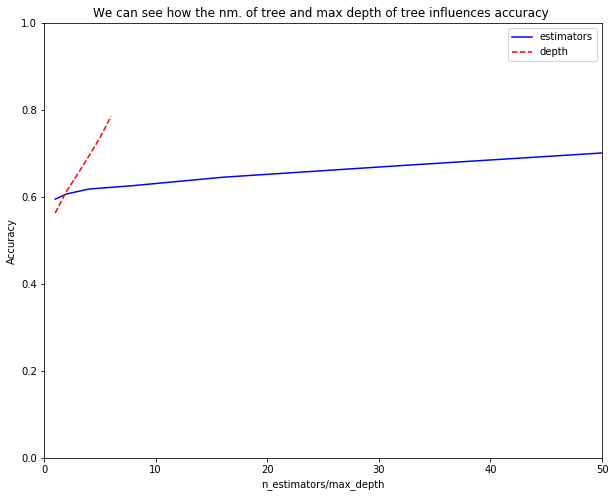

In [205]:
fig, ax = plt.subplots()
ax.plot(n_estimators, train_results, '-b', label='estimators')
ax.plot(max_depths, train_results_depth, '--r', label='depth')

plt.axis([0, 50, 0, 1])
plt.xlabel("n_estimators/max_depth")
plt.ylabel("Accuracy")
plt.title('We can see how the nm. of tree and max depth of tree influences accuracy ')
leg = ax.legend();
plt.show()

#### We can see here that the max_depth of the tree influences more the nm. of estimators.

In [206]:

clf_xgb = xgb.XGBClassifier(
                objective = 'multi:softmax',
                max_depth = 10,
                n_estimators=64)
clf_xgb.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=64, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [207]:
y_pred_xgb = clf_xgb.predict(X_test)
auc_score = multiclass_roc_auc_score(y_test,y_pred_xgb)
print("auc score: ",str(auc_score))

auc score:  0.8493816331630997


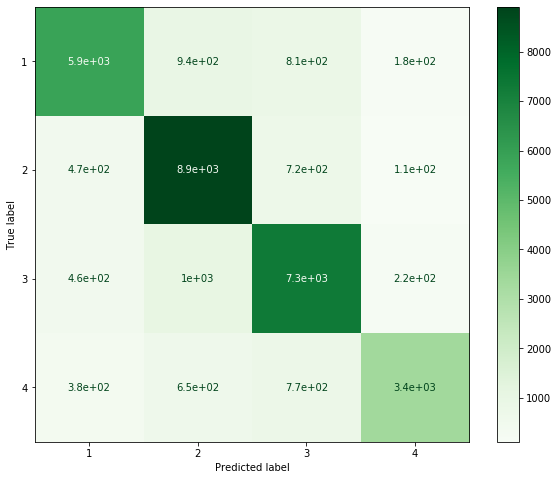

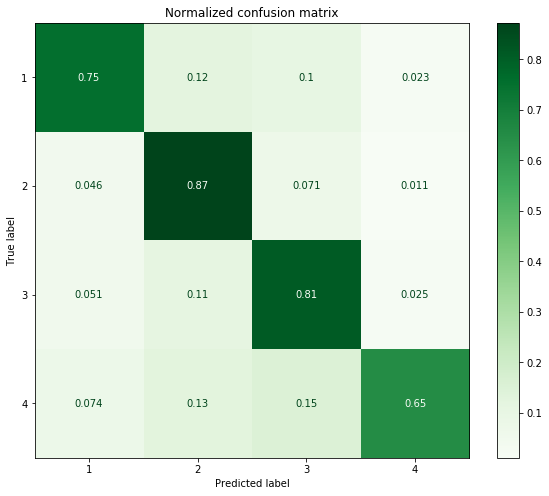

In [208]:
plot_matrix(clf_xgb,X_test,y_test,y_pred_xgb)

# We notice here that the classification for discount code 4 is not as good as the other codes. But mostly it's stable and we got good results

### The most significant parameter that affects the model learning is number of estimators/trees & max depth of the tree. (see explanition above)

## Decision Tree

In [209]:
max_depths = np.linspace(1, 32, 32, endpoint=True)
train_results = []
test_results = []
for max_depth in max_depths:
   dt = tree.DecisionTreeClassifier(max_depth=max_depth)
   dt.fit(X_train, y_train)
   train_pred = dt.predict(X_train)
   #false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   #roc_auc = auc(false_positive_rate, true_positive_rate)
   # Add auc score to previous train results
   #train_results.append(roc_auc)
   y_pred = dt.predict(X_test)
   auc_score = multiclass_roc_auc_score(y_test,y_pred)
   train_results.append(auc_score) 
   print(" auc score: for " + str(max_depth) + " depth: " + str(auc_score))



 

 auc score: for 1.0 depth: 0.5196914090137672
 auc score: for 2.0 depth: 0.5196914090137672
 auc score: for 3.0 depth: 0.5220008162983841
 auc score: for 4.0 depth: 0.5534210775685178
 auc score: for 5.0 depth: 0.5638794206765775
 auc score: for 6.0 depth: 0.5740482879920922
 auc score: for 7.0 depth: 0.5886419600091557
 auc score: for 8.0 depth: 0.6004814314572234
 auc score: for 9.0 depth: 0.6079196548140642
 auc score: for 10.0 depth: 0.6199315596686009
 auc score: for 11.0 depth: 0.6236084606189737
 auc score: for 12.0 depth: 0.6297634756212152
 auc score: for 13.0 depth: 0.636415666603819
 auc score: for 14.0 depth: 0.6439377133403319
 auc score: for 15.0 depth: 0.6519123198308976
 auc score: for 16.0 depth: 0.6618403933318722
 auc score: for 17.0 depth: 0.670927165580067
 auc score: for 18.0 depth: 0.6820951410570097
 auc score: for 19.0 depth: 0.6922109321867459
 auc score: for 20.0 depth: 0.7060144098598864
 auc score: for 21.0 depth: 0.7150417263314632
 auc score: for 22.0 dep

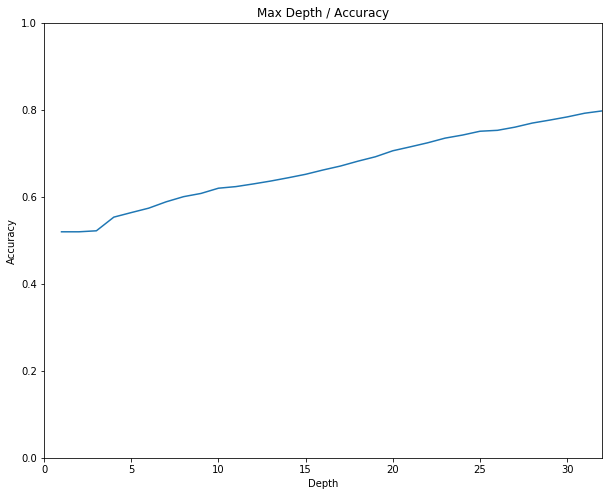

In [210]:
plt.plot(max_depths, train_results)
plt.axis([0, 32, 0, 1])
plt.xlabel("Depth")
plt.ylabel("Accuracy")
plt.title('Max Depth / Accuracy')
plt.show()

#### we notice here the effect of depth of tree on accuarcy - the deeper the higher the accuracy 

In [211]:

gini_dep3 = tree.DecisionTreeClassifier(criterion="gini", max_depth=500,min_samples_leaf=2)
gini_dep3.fit(X_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=500, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [212]:

y_pred = gini_dep3.predict(X_test)
print(accuracy_score(y_test,y_pred)*100)

76.39950295122709


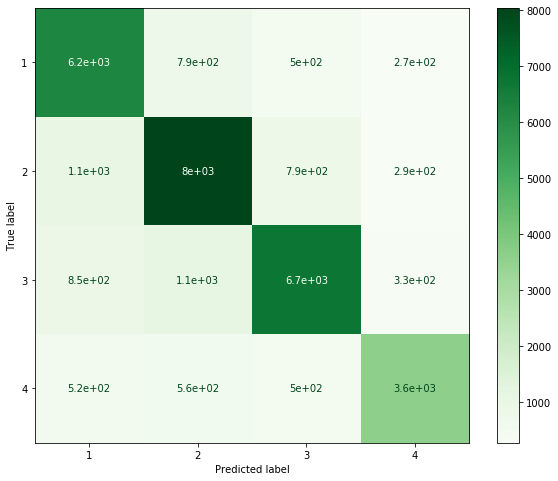

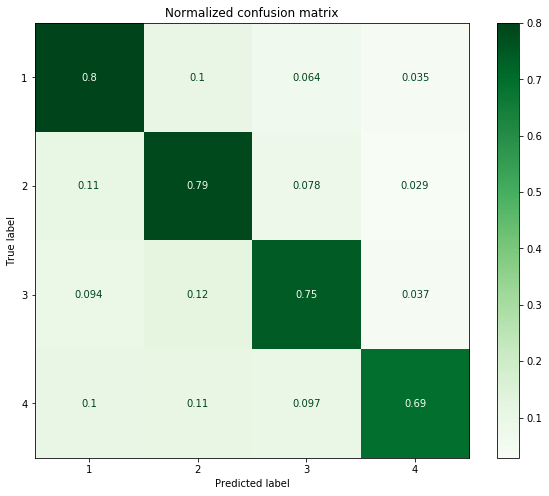

array([[6242,  786,  500,  273],
       [1083, 8042,  792,  291],
       [ 851, 1110, 6726,  332],
       [ 518,  562,  499, 3583]])

In [213]:
plot_matrix(gini_dep3,X_test,y_test, y_pred)
confusion_matrix(y_test, y_pred)

# Here we notice the for the classification of discount code 4 was not satisfiying and we expected more from the decison tree model.

In [214]:
n_classes = 4
y_prob = gini_dep3.predict_proba(X_test)
macro_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo",
                                  average="macro")
weighted_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo",
                                     average="weighted")
macro_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr",
                                  average="macro")
weighted_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr",
                                     average="weighted")
print("One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovo, weighted_roc_auc_ovo))
print("One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovr, weighted_roc_auc_ovr))

One-vs-One ROC AUC scores:
0.871525 (macro),
0.871177 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.871286 (macro),
0.870505 (weighted by prevalence)


In [215]:
# AUC ROC for multiclass model
multiclass_roc_auc_score(y_test, y_pred)

0.8381294349864792

### We notice that the deeper the tree the higher the accuarcy is. We see that our model overfits for large depth values. The tree perfectly predicts all of the train data.

### and so the most significant parameter that affects the model learning is max_depth.

## Random Forest

In [216]:
# Estimator
clf = RandomForestClassifier(n_estimators=50)
clf = clf.fit(X_train, y_train)

In [217]:
# Accuracy
y_pred = clf.predict(X_test)
print(accuracy_score(y_test,y_pred)*100)

84.51382416899659


In [218]:
macro_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo",
                                  average="macro")
weighted_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo",
                                     average="weighted")
macro_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr",
                                  average="macro")
weighted_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr",
                                     average="weighted")
print("One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovo, weighted_roc_auc_ovo))
print("One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovr, weighted_roc_auc_ovr))

One-vs-One ROC AUC scores:
0.871525 (macro),
0.871177 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.871286 (macro),
0.870505 (weighted by prevalence)


In [219]:
# AUC ROC for multiclass model
multiclass_roc_auc_score(y_test, y_pred)

0.8930879501464704

We found a sweet spot around 50 trees.

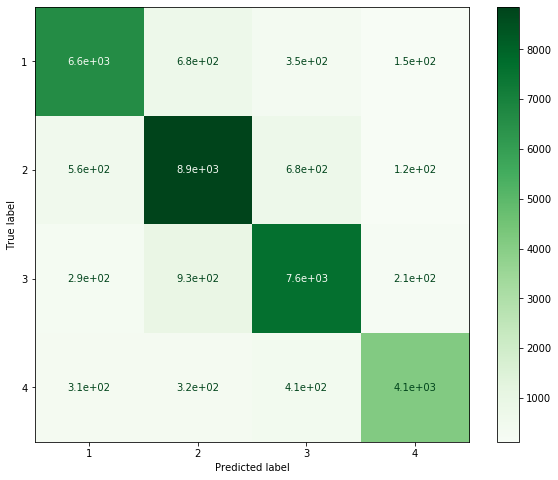

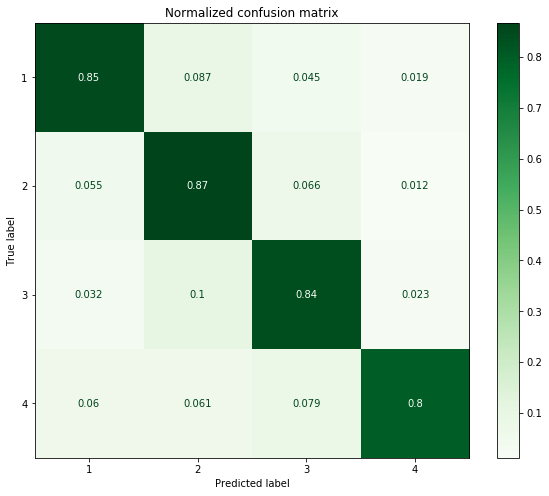

In [220]:
#confusion matrix for random forest
plot_matrix(clf,X_test,y_test,y_pred)

# In the random forest we notice that all the classifiacations of the model are very stable and we are satisfied of it.

### The most significant parameter that affects the model learning is the number of estimators (trees)

# Neural Network

## Network Classes

In [221]:
class Dataset(data.Dataset):
    def __init__(self,X,Y):
        self.X = X
        self.Y = Y
    
    def __len__(self):
        return len(self.Y)
    
    def __getitem__(self,index):
        X = self.X[index].float().reshape(-1)
        Y = self.Y[index].long()
        return X,Y

Here we’re inheriting from nn.Module. this class creats the network architecture. The function __init__ gets a list of sizes, and using for loop builds the layers of the net. the forward function takes in a tensor x and passes it through the layers we defined in the __init__ method.

In [222]:
class Simple_MLP(nn.Module):
    def __init__(self,size_list):
        super(Simple_MLP,self).__init__()
        layers=[]
        self.size_list = size_list
        for i in range(len(size_list) -2):
            layers.append(nn.Linear(size_list[i],size_list[i+1]))
            layers.append(nn.ReLU())
            #layers.append(nn.Sigmoid())
            #layers.append(nn.Softmax(dim=0))
        layers.append(nn.Linear(size_list[-2],size_list[-1]))
        layers.append(nn.Softmax())
        self.net = nn.Sequential(*layers)
        
    def forward(self,x):
        return self.net(x)

## Network Core Helper Functions

The following functions, train_epoch and test_epoch, get the network model we defined in class Simple_MLP, the dataset and the parameters in which the network will operate.
The training function activates the learning process of the network by comparing the desired output and the existing one. the test function uses the weighes calculater in the train and makes a similar process but on a new part of the data and without learning process. It can only learn the net's capabilities.

In [223]:
import time
def train_epoch(model,train_loader,criterion,optimizer):
    model.train()
    model.to(device)
    running_loss=0.0
    
    start_time = time.time()
    for batch_idx, (data,target) in enumerate(train_loader):
        optimizer.zero_grad()
        data = data.to(device)
        target = target.to(device)
        
        outputs = model(data)
        loss = criterion(outputs,target)
        running_loss += loss.item()
        
        loss.backward()
        optimizer.step()
    
    end_time = time.time()   
    running_loss /= len(train_loader)
    print("Train Loss: ", running_loss, ' Time: ', end_time-start_time)
    return running_loss

In [224]:
def test_epoch(model,test_loader,criterion):
    with torch.no_grad():
        model.eval()
        model.to(device)
        
        running_loss = 0.0
        total_predictions = 0.0
        correct_predictions = 0.0
        
        for batch_idx, (data,target) in enumerate(test_loader):
            data = data.to(device)
            target = target.to(device)
            outputs = model(data)
            
            _, predicted = torch.max(outputs.data,1)
            
            total_predictions += target.size(0)
            correct_predictions += (predicted==target).sum().item()
            
            loss = criterion(outputs,target).detach()
            running_loss += loss.item()
        running_loss /= len(test_loader)
        acc = (correct_predictions/total_predictions)*100.0
        print('Test Loss: ',running_loss)
        print('Test Acc: ',acc,'%')
        return running_loss,acc,predicted,target
        #return running_loss,acc

### Data Handling

In [225]:
pre_work_df = pd.read_csv("Classification_data_ready.csv")
pre_work_df

,Unnamed: 0,Snapshot ID,Snapshot Date,Checkin Date,Days,Original Price,Discount Price,Discount Code,Available Rooms,Hotel Name,Hotel Stars,DayDiff,WeekDay,DiscountDiff,DiscountPerc
0,0,1,7/17/2015 0:00,8/12/2015 0:00,5,1178,1040,1,6,Best Western Plus Seaport Inn Downtown,3,26,2,138,11.714771
1,1,1,7/17/2015 0:00,8/19/2015 0:00,5,1113,982,1,8,Best Western Plus Seaport Inn Downtown,3,33,2,131,11.769991
2,3,1,7/17/2015 0:00,7/26/2015 0:00,5,1739,1667,1,18,Eventi Hotel a Kimpton Hotel,4,9,6,72,4.140311
3,5,1,7/17/2015 0:00,8/7/2015 0:00,5,1436,1345,1,9,Grand Hyatt New York,4,21,4,91,6.337047
4,6,1,7/17/2015 0:00,8/9/2015 0:00,5,1616,1525,1,5,Grand Hyatt New York,4,23,6,91,5.631188
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107294,187837,99,8/15/2015 0:00,9/7/2015 0:00,5,2215,2061,4,83,NOMO SOHO,5,23,0,154,6.952596
107295,187841,99,8/15/2015 0:00,8/27/2015 0:00,5,1245,1075,4,-1,Cassa Hotel 45th Street,4,12,3,170,13.654618
107296,187844,99,8/15/2015 0:00,9/4/2015 0:00,5,2105,1865,4,4,The Jade Hotel,4,20,4,240,11.401425
107297,187845,99,8/15/2015 0:00,8/20/2015 0:00,5,1456,1397,4,8,Hyatt Union Square New York,4,5,3,59,4.052198


In addition to the data processing we conducted earlier, here we have turned the information on the dates into dummies separated by day month and year.
This way the model will be able to give relative weight to the day of the month and year, rather than looking at them as a number that does not symbolize size.

In [226]:
pre_work_df["Snapshot Date"] = pd.to_datetime(pre_work_df["Snapshot Date"])
pre_work_df["Checkin Date"] = pd.to_datetime(pre_work_df["Checkin Date"])
pre_work_df["Snapshot Year"] = pre_work_df["Snapshot Date"].dt.year
pre_work_df["Snapshot Month"] = pre_work_df["Snapshot Date"].dt.month
pre_work_df["Snapshot Day"] = pre_work_df["Snapshot Date"].dt.day
pre_work_df["Checkin Year"] = pre_work_df["Checkin Date"].dt.year
pre_work_df["Checkin Month"] = pre_work_df["Checkin Date"].dt.month
pre_work_df["Checkin Day"] = pre_work_df["Checkin Date"].dt.day

In [227]:
columns_to_nn = ['Snapshot Year','Snapshot Month','Snapshot Day', 'Checkin Year','Checkin Month','Checkin Day', 'Hotel Name', 'WeekDay', 'DayDiff', 'Discount Code']

In [228]:
df = pre_work_df.filter(columns_to_nn)

In [229]:
df = df.dropna()

In [230]:
df

,Snapshot Year,Snapshot Month,Snapshot Day,Checkin Year,Checkin Month,Checkin Day,Hotel Name,WeekDay,DayDiff,Discount Code
0,2015,7,17,2015,8,12,Best Western Plus Seaport Inn Downtown,2,26,1
1,2015,7,17,2015,8,19,Best Western Plus Seaport Inn Downtown,2,33,1
2,2015,7,17,2015,7,26,Eventi Hotel a Kimpton Hotel,6,9,1
3,2015,7,17,2015,8,7,Grand Hyatt New York,4,21,1
4,2015,7,17,2015,8,9,Grand Hyatt New York,6,23,1
...,...,...,...,...,...,...,...,...,...,...
107294,2015,8,15,2015,9,7,NOMO SOHO,0,23,4
107295,2015,8,15,2015,8,27,Cassa Hotel 45th Street,3,12,4
107296,2015,8,15,2015,9,4,The Jade Hotel,4,20,4
107297,2015,8,15,2015,8,20,Hyatt Union Square New York,3,5,4


In [231]:
to_dummy = ['Hotel Name','Snapshot Year','Snapshot Month','Snapshot Day', 'Checkin Year','Checkin Month','Checkin Day','WeekDay', 'DayDiff']
df1 = pd.get_dummies(data=df, columns=to_dummy)
df1

,Discount Code,Hotel Name_1 Hotel Central Park,Hotel Name_36 Hudson Hotel,Hotel Name_6 Columbus - a SIXTY Hotel,Hotel Name_70 Park Avenue Hotel a Kimpton Hotel,Hotel Name_AKA Central Park,Hotel Name_Ace Hotel New York,Hotel Name_Airport Hotel Inn & Suites - Newark Airport,Hotel Name_Airway Inn at LaGuardia,Hotel Name_Aloft Harlem,...,DayDiff_25,DayDiff_26,DayDiff_27,DayDiff_28,DayDiff_29,DayDiff_30,DayDiff_31,DayDiff_32,DayDiff_33,DayDiff_34
0,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107294,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
107295,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
107296,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
107297,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [232]:
features = list(df1.columns)
y = df1['Discount Code'] -1
features.remove('Discount Code')
X = df1[features]
features

['Hotel Name_1 Hotel Central Park',
 'Hotel Name_36 Hudson Hotel',
 'Hotel Name_6 Columbus - a SIXTY Hotel',
 'Hotel Name_70 Park Avenue Hotel a Kimpton Hotel',
 'Hotel Name_AKA Central Park',
 'Hotel Name_Ace Hotel New York',
 'Hotel Name_Airport Hotel Inn & Suites - Newark Airport',
 'Hotel Name_Airway Inn at LaGuardia',
 'Hotel Name_Aloft Harlem',
 'Hotel Name_Aloft Manhattan Downtown - Financial District',
 'Hotel Name_Aloft New York Brooklyn Hotel',
 'Hotel Name_Americana Inn',
 'Hotel Name_Ameritania at Times Square',
 'Hotel Name_Amsterdam Court Hotel',
 'Hotel Name_AnYi Guesthouse Flushing',
 'Hotel Name_Anchor Inn',
 'Hotel Name_Andaz 5th Avenue - a concept by Hyatt',
 'Hotel Name_Andaz Wall Street - a concept by Hyatt',
 'Hotel Name_Archer Hotel New York',
 'Hotel Name_Arlington Place Bed & Breakfast',
 'Hotel Name_Avalon Hotel',
 'Hotel Name_Baccarat Hotel and Residences New York',
 'Hotel Name_Bed & Breakfast Little Italy',
 'Hotel Name_Bellerose Inn',
 'Hotel Name_Bentley 

In [233]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3)

A Tensor is a multi-dimensional matrix containing elements of a single data type. This makes it easier for the net whos gets a lot of featurs and needs to learn the connections between them.

In [234]:
X_train_tensor = torch.from_numpy(X_train.values).float()
X_test_tensor = torch.from_numpy(X_test.values).float()
y_train_tensor = torch.from_numpy(y_train.values).float()
y_test_tensor = torch.from_numpy(y_test.values).float()

In [235]:
train_dataset = Dataset(X_train_tensor,y_train_tensor)
test_dataset = Dataset(X_test_tensor,y_test_tensor)

In [236]:
train_loader_args = dict(shuffle=True,batch_size=200)
train_loader = DataLoader(train_dataset,**train_loader_args)

In [237]:
test_loader_args = dict(shuffle=True,batch_size=200)
test_loader = DataLoader(test_dataset,**test_loader_args)

### Define the network for training with optimizer which takes part in the loss calculatin, and the criterion which define the net transitions. Here we also initialize the array of sizes that will define the layers in the model

In [238]:

model = Simple_MLP([676,330,220,30,4])
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())
device = torch.device("cpu")
print(model)

Simple_MLP(
  (net): Sequential(
    (0): Linear(in_features=676, out_features=330, bias=True)
    (1): ReLU()
    (2): Linear(in_features=330, out_features=220, bias=True)
    (3): ReLU()
    (4): Linear(in_features=220, out_features=30, bias=True)
    (5): ReLU()
    (6): Linear(in_features=30, out_features=4, bias=True)
    (7): Softmax(dim=None)
  )
)


Here we define for the network how many cycles we want it to run, and in the arrays we will save the results of each of its runs to check how much it has improved. The main measure for this, is the size of the error, i.e the difference between what is desired for the prediction to be and what the network really predicted.

In [239]:
n_epoch =50
Train_loss = []
Test_loss = []
Test_acc = []
Test_pred = []
Test_correct_pred = []
for i in range(n_epoch):
    train_loss = train_epoch(model,train_loader,criterion,optimizer)
    test_loss,test_acc,test_pred,test_correct_pred = test_epoch(model,test_loader,criterion)
    Train_loss.append(train_loss)
    Test_loss.append(test_loss)
    Test_acc.append(test_acc)
    Test_pred.append(test_pred)
    Test_correct_pred.append(test_correct_pred)
    print('='*50)

/Users/tomeryona/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Train Loss:  1.3038963136520791  Time:  4.381905794143677
Test Loss:  1.2548948593021179
Test Acc:  47.39360049704877 %
Train Loss:  1.2099433848832517  Time:  4.109578847885132
Test Loss:  1.1876007955266823
Test Acc:  54.68157812985399 %
Train Loss:  1.1519493333836819  Time:  4.427209138870239
Test Loss:  1.158875897063972
Test Acc:  57.713575644610124 %
Train Loss:  1.118526686696296  Time:  4.450135707855225
Test Loss:  1.1496494164378006
Test Acc:  58.608263435849636 %
Train Loss:  1.0932506899884407  Time:  4.711763143539429
Test Loss:  1.1357390451135103
Test Acc:  60.14911463187326 %
Train Loss:  1.0748038666045412  Time:  4.61000394821167
Test Loss:  1.1258247105971626
Test Acc:  61.17117117117117 %
Train Loss:  1.0589277003990842  Time:  4.710113048553467
Test Loss:  1.1182651008878435
Test Acc:  61.98508853681267 %
Train Loss:  1.0458465586317347  Time:  4.864773988723755
Test Loss:  1.1124617275984392
Test Acc:  62.609506057781914 %
Train Loss:  1.035512623317698  Time:  5

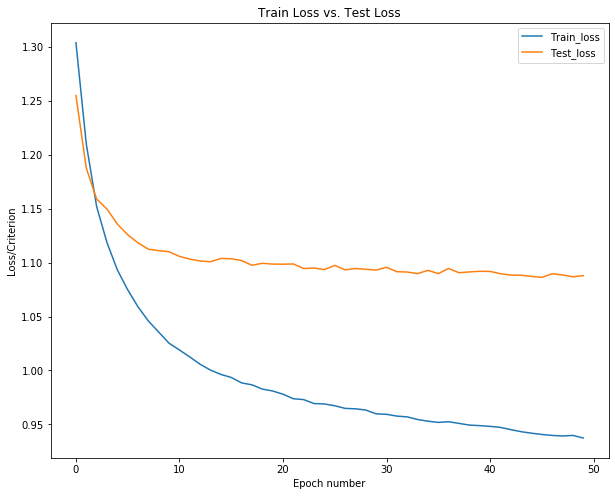

In [240]:
plt.title('Train Loss vs. Test Loss')
plt.xlabel('Epoch number')
plt.ylabel('Loss/Criterion')
plt.plot(Train_loss)
plt.plot(Test_loss)
plt.legend(['Train_loss', 'Test_loss'], loc='upper right')
plt.show()

In this graph we can see the learning process of the network from the magnitude of the error of the process, which goes down in every epoch. That is, there is a learning process.

In this graph we can see the learning process of the network from the magnitude of the error of the process, which goes down in every epoch. That is, there is a learning process.

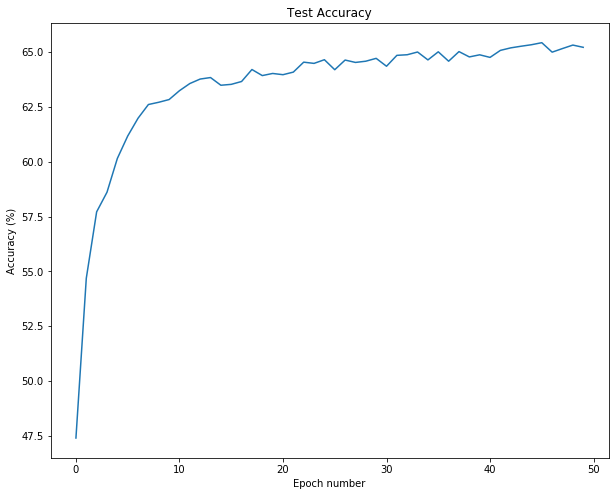

In [241]:
plt.title('Test Accuracy')
plt.xlabel('Epoch number')
plt.ylabel('Accuracy (%)')
plt.plot(Test_acc)

In this graph we see the error of the model in each epoch at the validation stage. If validation increases while the training error decreases, we can conclude a state of over-fitting of the model. we wish to see validation decreases along with training loss decreases

In [242]:
a = torch.cat(Test_correct_pred,0)
b=torch.cat(Test_pred,0)
print(a.shape)
print(b.shape)

torch.Size([9500])
torch.Size([9500])


In [243]:
cm = confusion_matrix(a, b)
cm

array([[1473,  464,  276,   93],
       [ 296, 2220,  446,   82],
       [ 233,  542, 1791,  131],
       [ 227,  380,  291,  555]])

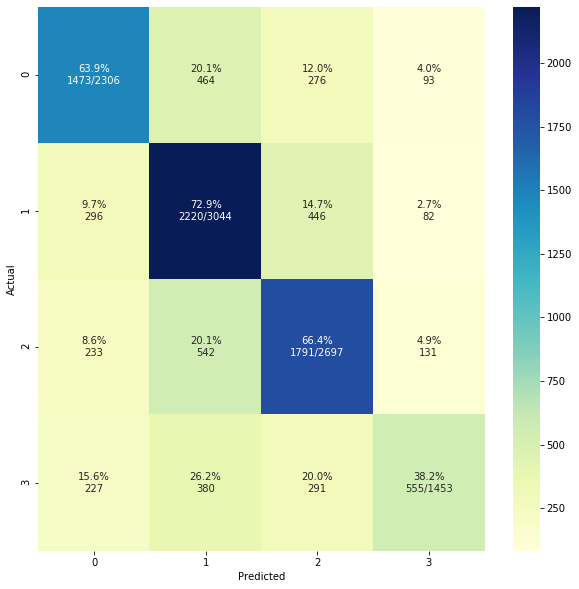

In [244]:
def plot_cm(y_true, y_pred, figsize=(10,10)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)
    
plot_cm(a, b)

### We can see that the NN gives a better prediction for disc. code 1(code 2) and less sufficent for code 3 (code 4) 
### by the way we changed the number of the code in order to work with network

In [245]:
corr_pred=[]
pred = []
for i in Test_correct_pred:
    for j in i:
        corr_pred.append(j.tolist())
    
for i in Test_pred:
    for j in i:
        pred.append(j.tolist())

In [250]:
corr_pred = np.array(corr_pred)
pred = np.array(pred)

In [252]:
multiclass_roc_auc_score(corr_pred,pred)

0.7384260541513818

### The most significant parameter that affects the NN model learning is the activation function and the loss function

# Comparison between all classification algorithims

In [253]:
df_b2.describe()

,Snapshot Date,Checkin Date,WeekDay,DayDiff,Discount Code
count,187848.000000,187848.000000,187848.000000,187848.000000,187848.000000
mean,9041.980745,9059.446430,2.917763,17.465685,2.434186
std,46.982385,47.588446,1.840536,10.040225,1.005191
min,8962.000000,8963.000000,0.000000,1.000000,1.000000
25%,9001.000000,9018.000000,2.000000,9.000000,2.000000
50%,9043.000000,9061.000000,3.000000,18.000000,2.000000
75%,9077.000000,9094.000000,4.000000,26.000000,3.000000
max,9130.000000,9164.000000,6.000000,34.000000,4.000000


In [254]:


workable_df['WeekDay'] = workable_df.WeekDay.astype('category')
workable_df['DayDiff'] = workable_df.DayDiff.astype('category')
workable_df.dtypes

Unnamed: 0                                   int64
Snapshot ID                                  int64
Snapshot Date                                int64
Checkin Date                                 int64
Days                                         int64
                                             ...  
Hotel Name_YOTEL New York at Times Square    uint8
Hotel Name_Z NYC Hotel                       uint8
Hotel Name_citizenM New York Times Square    uint8
Hotel Name_ink48 hotel a Kimpton Hotel       uint8
Hotel Name_the Quin                          uint8
Length: 568, dtype: object

In [255]:
workable_df['DayDiff']

0         26
1         33
3          9
5         21
6         23
          ..
187837    23
187841    12
187844    20
187845     5
187846    18
Name: DayDiff, Length: 107299, dtype: category
Categories (34, int64): [1, 2, 3, 4, ..., 31, 32, 33, 34]

/Users/tomeryona/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


NB: 0.213310 (0.005523)


/Users/tomeryona/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


RF: 0.536901 (0.037574)


/Users/tomeryona/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


CART: 0.504384 (0.034191)


/Users/tomeryona/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


XGB: 0.486360 (0.018357)


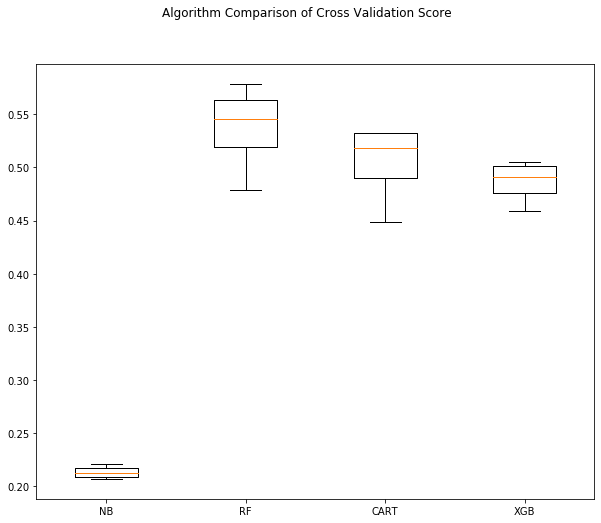

In [256]:
# Compare Algorithms
import pandas
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
# load dataset
names = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class']
dataframe = workable_df
array = dataframe.values
features = list(workable_df.columns)
Y = y
features.remove('Discount Code')
#X = workable_df[features]
# prepare configuration for cross validation test harness
seed = 7
# prepare models
models = []
models.append(('NB', GaussianNB()))
models.append(('RF', RandomForestClassifier(n_estimators=50)))
models.append(('CART', DecisionTreeClassifier(criterion="gini", max_depth=500,min_samples_leaf=2)))
models.append(('XGB', xgb.XGBClassifier(objective = 'multi:softmax',max_depth = 10,n_estimators=64)))
# evaluate each model in turn
results = []
names = []
#names.append('NN')
#results.append(Test_acc)
scoring = 'accuracy'
for name, model in models:
    kfold = model_selection.KFold(n_splits=4, random_state=seed)
    cv_results = model_selection.cross_val_score(model, X, Y, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    #y_pred_gb = model.predict(X_test)
    #auc_score = multiclass_roc_auc_score(y_test,y_pred_gb)
    #msg2 = "auc score for model %s: %f" % (name, auc_score)
    print(msg)
# boxplot algorithm comparison

fig = plt.figure()

fig.suptitle('Algorithm Comparison of Cross Validation Score')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

### Because the classes are balanced we can use AUC and accuracy only to evaluate our models

# Section C - Clustering 

## Clustering Algorithms

In [257]:
p_df.describe()

Checkin Date  10/1/2015 0:00                                      \
Discount Code              1           2           3           4   
count             149.000000  149.000000  149.000000  149.000000   
mean                0.822777    1.468383    1.190961    1.438601   
std                 3.477372    5.126049    3.929550    4.835179   
min                -1.000000   -1.000000   -1.000000   -1.000000   
25%                -1.000000   -1.000000   -1.000000   -1.000000   
50%                -1.000000   -1.000000   -1.000000   -1.000000   
75%                 2.343750    2.890625    2.773438    2.734375   
max                19.218750   46.875000   21.796875   28.906250   

Checkin Date  10/14/2015 0:00                                      \
Discount Code               1           2           3           4   
count              149.000000  149.000000  149.000000  149.000000   
mean                 1.902318    2.145082    1.734165    0.720271   
std                  5.183027    3.789694    3.149421    2.576594   
min                 -1.000000   -1.000000   -1.000000   -1.000000   
25%                 -1.000000   -1.000000   -1.000000   -1.000000   
50%                 -1.000000    1.992187    1.992187   -1.000000   
75%                  3.125000    4.296875    3.632813    2.656250   
max                 28.125000   16.601562   14.062500   11.914062   

Checkin Date  10/15/2015 0:00              ... 9/18/2015 0:00              \
Discount Code               1           2  ...              3           4   
count              149.000000  149.000000  ...     149.000000  149.000000   
mean                 0.533557    1.346739  ...       1.642722    0.495910   
std                  2.886595    2.961981  ...       4.642926    3.345719   
min                 -1.000000   -1.000000  ...      -1.000000   -1.000000   
25%                 -1.000000   -1.000000  ...      -1.000000   -1.000000   
50%                 -1.000000   -1.000000  ...      -1.000000   -1.000000   
75%                  1.992187    3.085938  ...       3.554688   -1.000000   
max                 12.187500   11.718750  ...      26.718750   22.656250   

Checkin Date  9/30/2015 0:00                                      \
Discount Code              1           2           3           4   
count             149.000000  149.000000  149.000000  149.000000   
mean                1.495596    1.467072    1.266621    0.397284   
std                 5.154430    4.918676    3.954971    2.734947   
min                -1.000000   -1.000000   -1.000000   -1.000000   
25%                -1.000000   -1.000000   -1.000000   -1.000000   
50%                -1.000000   -1.000000   -1.000000   -1.000000   
75%                 3.085938    2.773438    2.851562    2.031250   
max                42.187500   35.156250   23.437500   13.281250   

Checkin Date  9/9/2015 0:00                                      
Discount Code             1           2           3           4  
count            149.000000  149.000000  149.000000  149.000000  
mean               1.369442    1.955747    1.050388    0.173133  
std                5.607337    5.788668    3.157829    2.432441  
min               -1.000000   -1.000000   -1.000000   -1.000000  
25%               -1.000000   -1.000000   -1.000000   -1.000000  
50%               -1.000000   -1.000000   -1.000000   -1.000000  
75%                2.851562    3.164062    3.125000   -1.000000  
max               50.390625   42.968750   14.062500   13.671875  

[8 rows x 160 columns]

In [258]:
X = df_c1

In [259]:
clusts = 4

when k = 4, silhoutete score is: 0.22274820418560312


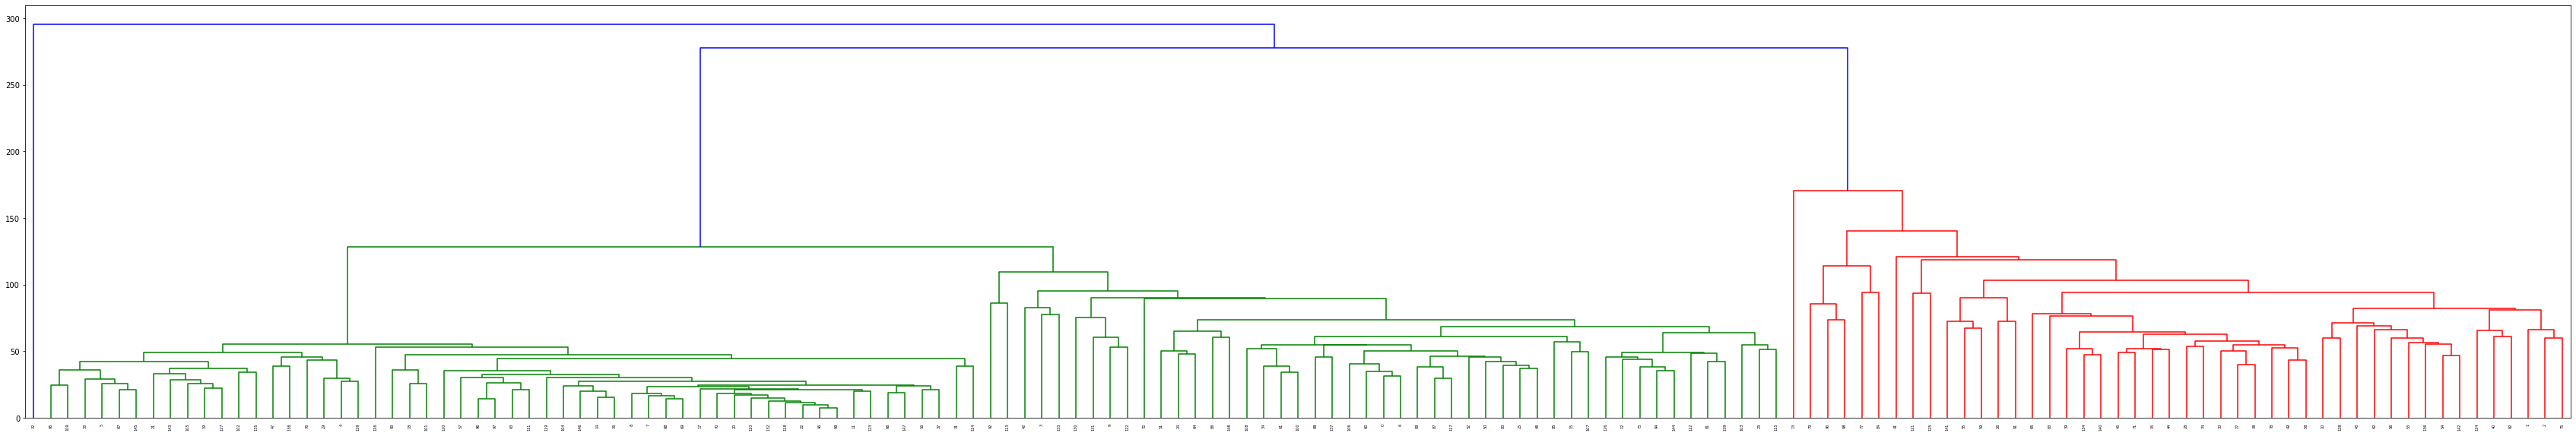

In [260]:
#dendogram ward

plt.figure(figsize=(60,10))
dendrogram_ward = sch.dendrogram(sch.linkage(X,method='ward'))

# Silloutes are needed. 
#how many clusters are needed not sure....
h_clustering = AgglomerativeClustering(n_clusters=clusts,linkage='ward')
preds = h_clustering.fit_predict(X)
score = silhouette_score(X, preds)
print("when k = " + str(clusts) + ", silhoutete score is: " + str(score))


#### *On the x axis you see labels. If you don't specify anything else they are the indices of your samples in X  (Checkin Date + Hotel Name + Discount Code) .
#### *On the y axis you see the distances (of the 'ward' method in our case).

### Let's notice that with given method if we cut a horizantol line at y=100~ which tells the calculated distance of  of 4 clusters.

when k = 4, silhoutete score is: 0.4428534132456165


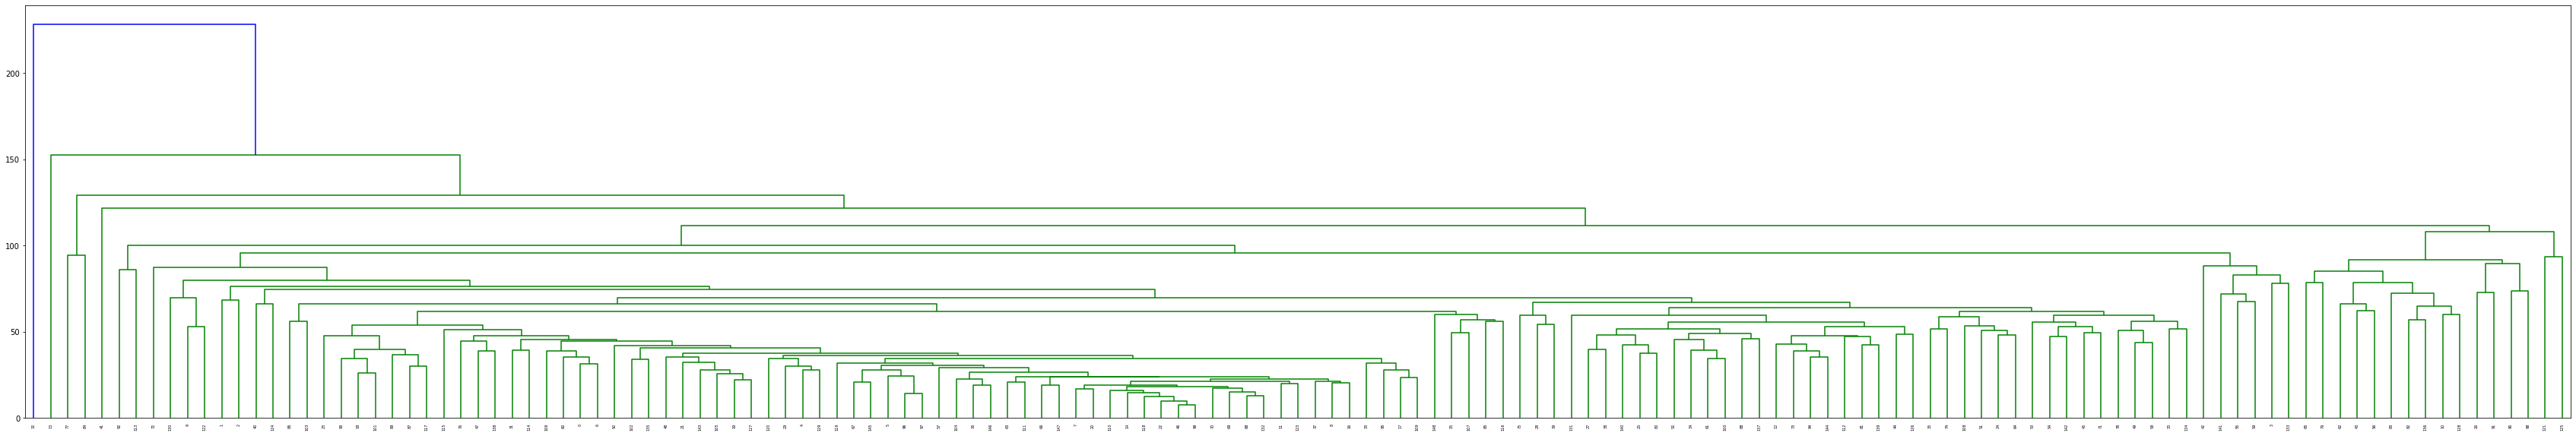

In [261]:
#dendogram complete

plt.figure(figsize=(60,10))
dendrogram_ward = sch.dendrogram(sch.linkage(X,method='complete'))

#how many clusters are needed not sure....
h_clustering = AgglomerativeClustering(n_clusters=clusts,linkage='complete')
preds = h_clustering.fit_predict(X)
score = silhouette_score(X, preds)
print("when k = " + str(clusts) + ", silhoutete score is: " + str(score))

when k = 4, silhoutete score is: 0.4428534132456165


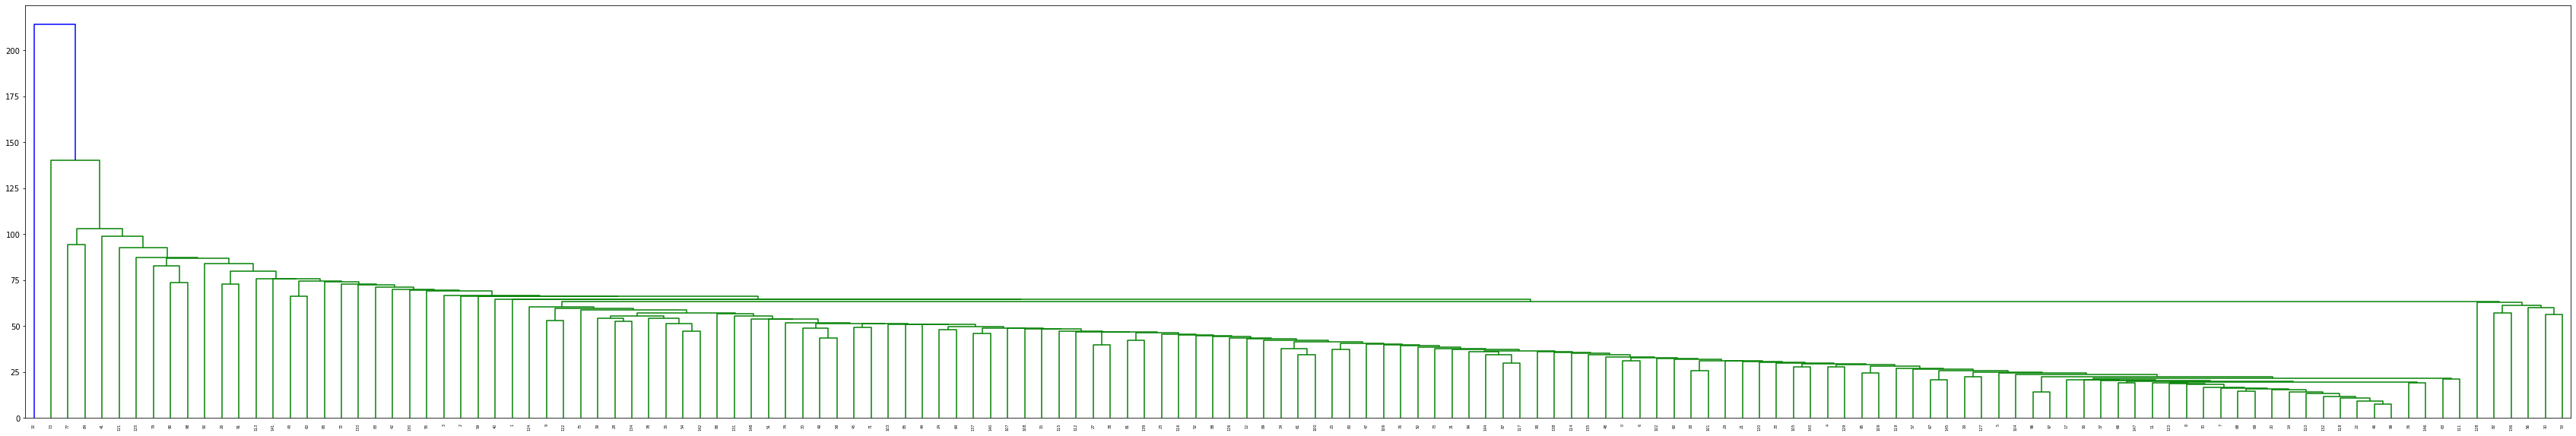

In [263]:
#dendogram average

plt.figure(figsize=(60,10))
dendrogram_ward = sch.dendrogram(sch.linkage(X,method='average'))

#how many clusters are needed not sure....
h_clustering = AgglomerativeClustering(n_clusters=clusts,linkage='average')
preds = h_clustering.fit_predict(X)
score = silhouette_score(X, preds)
print("when k = " + str(clusts) + ", silhoutete score is: " + str(score))

when k = 4, silhoutete score is: 0.42260082053459785


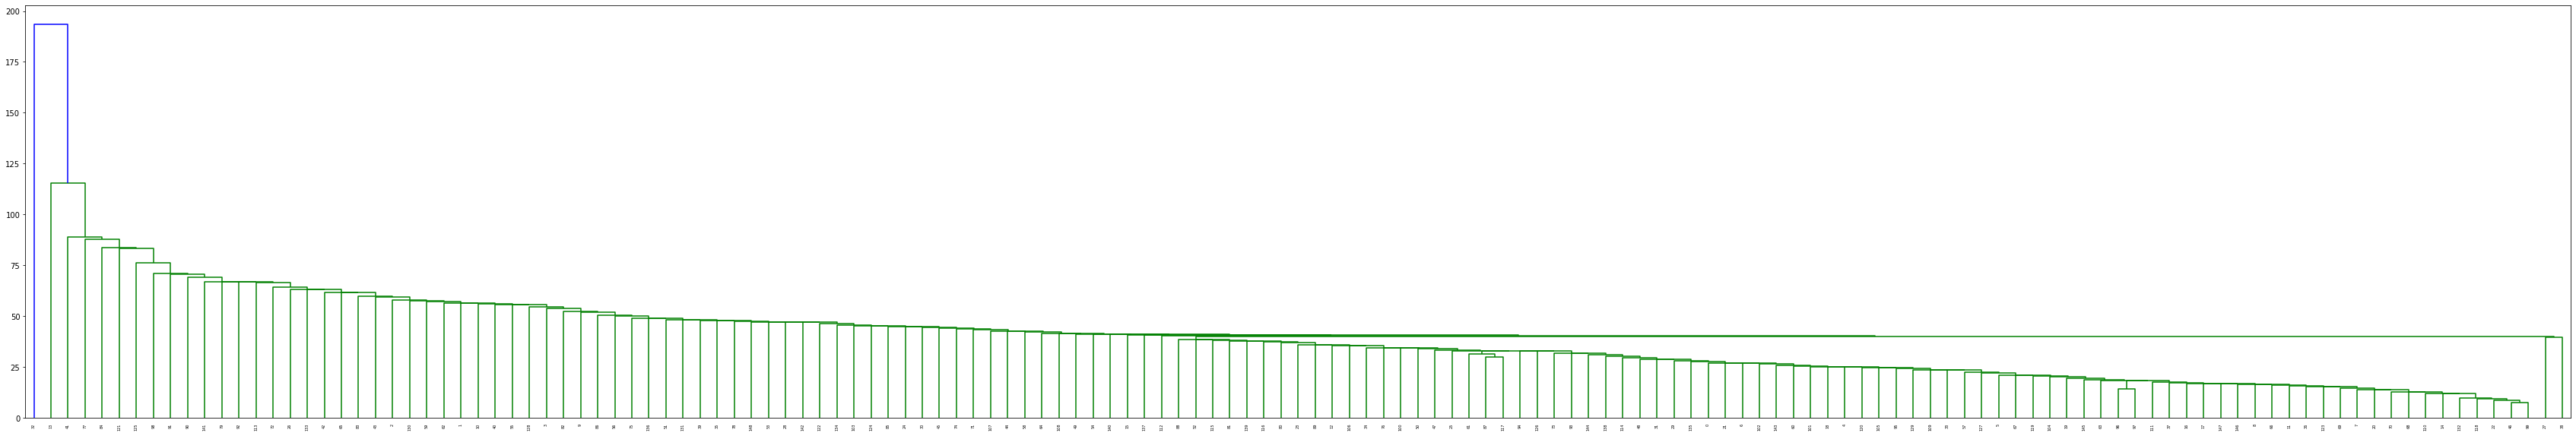

In [265]:
#dendogram single

plt.figure(figsize=(60,10))
dendrogram_ward = sch.dendrogram(sch.linkage(X,method='single'))


#how many clusters are needed not sure....
h_clustering = AgglomerativeClustering(n_clusters=clusts,linkage='single')
preds = h_clustering.fit_predict(X)
score = silhouette_score(X, preds)
print("when k = " + str(clusts) + ", silhoutete score is: " + str(score))

# Section D - Active Learning 

## First we look for a good estimator for our data

In [392]:
df_d_train

,Snapshot ID,Snapshot Date,Checkin Date,Days,Original Price,Discount Price,Discount Code,Available Rooms,Hotel Name,Hotel Stars,DayDiff,WeekDay,DiscountDiff,DiscountPerc
0,1,8962,8988,5,1178,1040,1,6,546,3,26,2,138,11.714771
2,1,8962,8989,5,4370,4240,1,3,349,5,27,3,130,2.974828
3,1,8962,8971,5,1739,1667,1,18,258,4,9,6,72,4.140311
4,1,8962,8988,5,1739,1672,1,3,258,4,26,2,67,3.852789
5,1,8962,8983,5,1436,1345,1,9,300,4,21,4,91,6.337047
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187843,99,8991,9011,5,1995,1935,4,-1,435,4,20,4,60,3.007519
187844,99,8991,9011,5,2105,1865,4,4,469,4,20,4,240,11.401425
187845,99,8991,8996,5,1456,1397,4,8,90,4,5,3,59,4.052198
187846,99,8991,9009,5,1705,1648,4,2,90,4,18,2,57,3.343109


### Regression

In [399]:
df_d_train = df_d_train[['Snapshot Date', 'Hotel Name','Checkin Date', 'Discount Code','Discount Price']]

In [410]:
features = ['Snapshot Date', 'Hotel Name','Checkin Date', 'Discount Code']
X = df_d_train[features].values
y = df_d_train.iloc[:,len(features):].values
X

array([[8962,  546, 8988,    1],
       [8962,  349, 8989,    1],
       [8962,  258, 8971,    1],
       ...,
       [8991,   90, 8996,    4],
       [8991,   90, 9009,    4],
       [8991,   90, 9011,    4]])

#### Scaling as recommended for regression

In [413]:
from sklearn.preprocessing import StandardScaler

st_x = StandardScaler()
st_y = StandardScaler()

In [414]:
X_Scld = st_x.fit_transform(X)
y_Scld = st_y.fit_transform(y)

#### Prepare for regressors

In [435]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_Scld, y_Scld, test_size=0.33, random_state=42)

## SVR

In [436]:
from sklearn.svm import SVR

In [437]:
model = SVR(kernel='rbf', degree=3, gamma='scale', coef0=0.0, tol=0.001, C=1.0, epsilon=0.1, shrinking=True, cache_size=200, verbose=False, max_iter=-1)

In [438]:
model.fit(X_train[:1000], y_train[:1000])

/Users/tomeryona/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [439]:
y_pred = model.predict(X_test)

In [440]:
from sklearn.metrics import r2_score
r2_score(y_test, y_pred)

0.029072893877225447

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


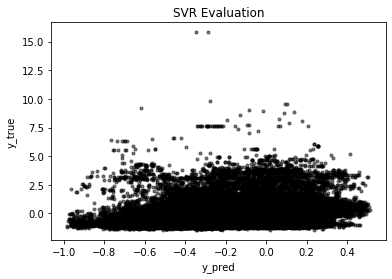

In [441]:
import numpy as np
import matplotlib.pyplot as plt

# # Create data
# N = 500
# x = np.random.rand(N)
# y = np.random.rand(N)
colors = (0, 0, 0)
area = np.pi*3

# Plot
plt.scatter(y_pred, y_test, s=area, c=colors, alpha=0.5)
plt.title('SVR Evaluation')
plt.xlabel('y_pred')
plt.ylabel('y_true')
plt.show()

### Appears that SVR is overfitted So we will try linear regression

### Linear Regression

In [442]:
from sklearn.linear_model import LinearRegression

model = LinearRegression(fit_intercept=True)

In [443]:
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [444]:
y_pred = model.predict(X_test)


In [445]:
from sklearn.metrics import r2_score
r2_score(y_test, y_pred)

0.01857018975889313

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


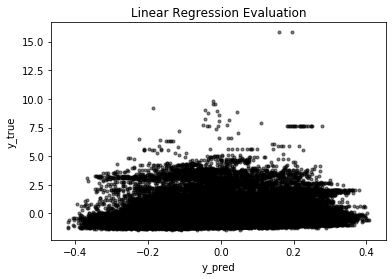

In [446]:
import numpy as np
import matplotlib.pyplot as plt

# # Create data
# N = 500
# x = np.random.rand(N)
# y = np.random.rand(N)
colors = (0, 0, 0)
area = np.pi*3

# Plot
plt.scatter(y_pred, y_test, s=area, c=colors, alpha=0.5)
plt.title('Linear Regression Evaluation')
plt.xlabel('y_pred')
plt.ylabel('y_true')
plt.show()

### R2 of Linear regression is better but still low.

#### Trying to active learn with Linear Regression wasn't possible with modAL
#### So we move on to classification

### Classification

In [525]:
features = ['Snapshot Date', 'Hotel Name','Checkin Date', 'Discount Code']
X = df_d_train[features].values
y = df_d_train.iloc[:,len(features):].values
X

array([[8962,  546, 8988,    1],
       [8962,  349, 8989,    1],
       [8962,  258, 8971,    1],
       ...,
       [8991,   90, 8996,    4],
       [8991,   90, 9009,    4],
       [8991,   90, 9011,    4]])

In [526]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [527]:
from sklearn import tree

# decision tree
gini_dep3 = tree.DecisionTreeClassifier(criterion="gini", max_depth=500,min_samples_leaf=2)

In [528]:
gini_dep3.fit(X_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=500, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [529]:
y_pred = gini_dep3.predict(X_test)

In [530]:
from sklearn.metrics import r2_score
r2_score(y_test, y_pred)

0.911215648855893

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


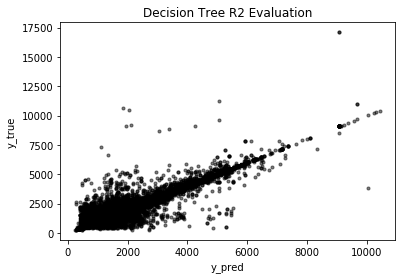

In [531]:
import numpy as np
import matplotlib.pyplot as plt

# # Create data
# N = 500
# x = np.random.rand(N)
# y = np.random.rand(N)
colors = (0, 0, 0)
area = np.pi*3

# Plot
plt.scatter(y_pred, y_test, s=area, c=colors, alpha=0.5)
plt.title('Decision Tree R2 Evaluation')
plt.xlabel('y_pred')
plt.ylabel('y_true')
plt.show()

### Like a breath of fresh air - the decision tree won our respect with it's r2 score

### Active Learn with Decision Tree

In [498]:
def active_selection(df, hotel_name, snapshot_date, discount_code):
    
    df = df[df['Hotel Name'] == hotel_name]
    df = df[df['Snapshot Date'] == snapshot_date]
    df = df[df['Discount Code'] == discount_code]
    selected_df = df
    return selected_df

In [504]:
active_selection(df_d_train,90,8991,4)

,Snapshot Date,Hotel Name,Checkin Date,Discount Code,Discount Price
187845,8991,90,8996,4,1397
187846,8991,90,9009,4,1648
187847,8991,90,9011,4,1743


In [532]:
import numpy as np
import matplotlib.pyplot as plt
from modAL.models import ActiveLearner
import modAL
from sklearn.metrics import r2_score
%matplotlib inline
#tree.DecisionTreeClassifier(criterion="gini", max_depth=500,min_samples_leaf=2)
def section_d_main(df_d_top40, queries, 
                   oracle,
                  strategy=modAL.uncertainty.entropy_sampling):
    
    
    y = df_d_top40['Discount Price'].values
    features = ['Snapshot Date', 'Hotel Name','Checkin Date', 'Discount Code']
    X = df_d_top40[features].values   
    
    # Give the active learner something to start from
    
    n_initial = 5
    initial_idx = np.random.choice(range(len(X)), size=n_initial, replace=True)
    X_training, y_training = X[initial_idx], y[initial_idx]
    
    # Define active learner
    active_learner = ActiveLearner(estimator=oracle,
    query_strategy=strategy,
    X_training=X_training, y_training=y_training.reshape(-1, 1))
    
    
    
    for hotel in df_d_top40['Hotel Name'].values:
        for snapshot in df_d_top40[df_d_top40['Hotel Name'] == hotel]['Snapshot Date'].values:
            for discount in [1, 2, 3, 4]:
                df_d_train = active_selection(df_d_top40,hotel,snapshot,discount)
                if not df_d_train.empty:
                    
                    #print("OK looking at " + str(df_d_train))
                    #print("***********")
                    
                    features = ['Snapshot Date', 'Hotel Name','Checkin Date', 'Discount Code']
                    X = df_d_train[features].values
                    #print("X is : " + str(X))
                    y = df_d_train['Discount Price'].values
                    #print("y is : " + str(y))
                    # Pool Prepare
#                     n_initial = 5
#                     initial_idx = np.random.choice(range(len(X)), size=n_initial, replace=True)
#                     X_training, y_training = X[initial_idx], y[initial_idx]
                    
                    #print("Just before training!!!!!!!! Excited??")
                    
                    for idx in range(queries):
                        query_idx, query_instance = active_learner.query(X)
                        active_learner.teach(X[query_idx].reshape(1, -1), y[query_idx].reshape(1, -1))
                        #print("$$$$$$$$$ Done teaching round $$$$$$$$")
                        
    # Test this query research
    
    y_test = df_d_top40['Discount Price'].values
    features = ['Snapshot Date', 'Hotel Name','Checkin Date', 'Discount Code']
    X_test = df_d_top40[features].values    
    
    y_pred = active_learner.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    return r2

In [538]:
df_d_top40 = df_d_test
r2_list = []
list_n_queries = [1, 2, 5,7, 10]
for q in list_n_queries:
    r2_list.append(section_d_main(df_d_top40.head(100),q,gini_dep3))

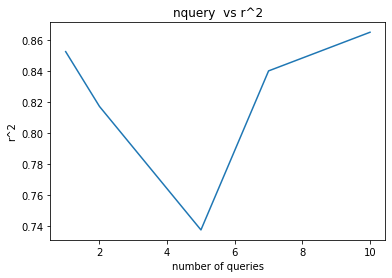

In [539]:
# plot queries and accuracy of r2

plt.title('nquery  vs r^2')
plt.xlabel('number of queries')
plt.ylabel('r^2')
plt.plot(list_n_queries,r2_list)

#### We can see here that at first our active model is overfitted. That could be because of the lack of examples that correspond to the combinations of hotel name + snapshot date + discount code. Because it's a pool based active model we have to first give him some labels from the pool and thus if the training data is small, our model will be overfitted at first. With each query of our trained oracle (a gini based decision tree with depth of 3) our active model get away from the overfitting due to the generlazation of our oracle. 